<a href="https://colab.research.google.com/github/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/CycleGAN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/XY_season_images.png?raw=1' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/horse2zebra.jpg?raw=1' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
!wget --no-check-certificate --no-proxy 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip'

--2020-05-29 07:49:16--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.39.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.39.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip.1’

summer2winter-yosem 100%[===================>] 127.58M  39.9MB/s    in 3.2s    

2020-05-29 07:49:19 (39.9 MB/s) - ‘summer2winter-yosemite.zip.1’ saved [133783376/133783376]



In [2]:
!unzip -o summer2winter-yosemite.zip

Streaming output truncated to the last 5000 lines.
  inflating: summer2winter_yosemite/summer/summer/2012-05-26 18:28:03.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-05-26 18:28:03.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-05-27 17:59:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-05-27 17:59:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-05-28 14:33:34.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-05-28 14:33:34.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-05-29 17:10:28.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-05-29 17:10:28.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-05-30 06:35:44.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-05-30 06:35:44.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 02:17:48.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer

In [0]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [0]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

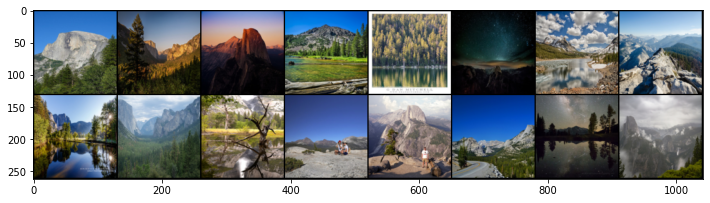

In [6]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

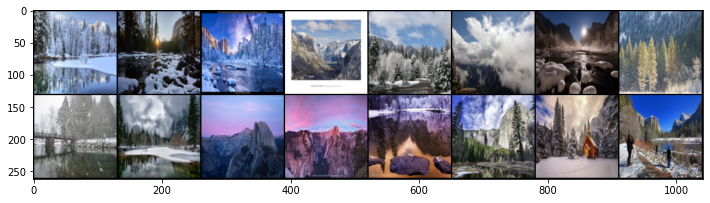

In [7]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0235)
Max:  tensor(1.)


In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [10]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9529)
Scaled max:  tensor(1.)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/discriminator_layers.png?raw=1' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        # 128x128x3
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 64x64x64
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 32x32x128
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 16x16x256
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 8x8x512
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=1, bias=False)
        # self.conv5 = nn.Conv2d(512, 1, 8, stride=1, padding=0, bias=False)

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/cyclegan_generator_ex.png?raw=1' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/resnet_50.png?raw=1' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/resnet_block.png?raw=1' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [0]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3

        self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        x = F.relu(self.conv1(x))
        x = x + self.conv2(x)
        return x
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [0]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        self.conv_dim = conv_dim
        self.n_res_blocks = n_res_blocks

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        # 128x128x3
        self.conv1 = conv(3, conv_dim, 4)
        # 64x64x64
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 32x32x128
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 16x16x256

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_block_list = []
        for layer in range(n_res_blocks):
            res_block_list.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*res_block_list)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        # 16x16x256
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        # 32x32x128
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # 64x64x64
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        # 128x128x3

        self.tanh = nn.Tanh()

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.res_blocks(x)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.tanh(self.deconv3(x))

        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [17]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [18]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/CycleGAN_loss.png?raw=1'/>

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/reconstruction_error.png?raw=1'/>

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss

### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [0]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2=0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/cycle_consistency_ex.png?raw=1' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
%cd '/content/drive/My Drive/Udacity/deep-learning-v2-pytorch/cycle-gan/'

#import helper.py
import imp 
helper = imp.new_module('helpers')
exec(open("./helpers.py").read(), helper.__dict__)

/content/drive/My Drive/Udacity/deep-learning-v2-pytorch/cycle-gan


In [0]:
# import save code
from helpers import save_samples, checkpoint

In [24]:
%cd '/content/'

/content


In [0]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        # print('images_X.size()', images_X.size())
        # print('out_x.size()', out_x.size())
        # print('D_X_real_loss.size()', D_X_real_loss.size())
        # print('D_X_real_loss', D_X_real_loss)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        # print('images_Y.size()', images_Y.size())
        # print('fake_X.size()', fake_X.size())

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        # print('fake_X.size()', fake_X.size())
        # print('out_x.size()', out_x.size())
        # print('D_X_fake_loss.size()', D_X_fake_loss.size())
        # print('D_X_fake_loss', D_X_fake_loss)
        # break

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [26]:
%mkdir 'samples_cyclegan'

mkdir: cannot create directory ‘samples_cyclegan’: File exists


In [27]:
n_epochs = 10000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/10000] | d_X_loss: 0.4092 | d_Y_loss: 0.2986 | g_total_loss: 10.7976
Epoch [   20/10000] | d_X_loss: 0.3683 | d_Y_loss: 0.2462 | g_total_loss: 8.9295
Epoch [   30/10000] | d_X_loss: 0.3092 | d_Y_loss: 0.2594 | g_total_loss: 9.2035
Epoch [   40/10000] | d_X_loss: 0.1716 | d_Y_loss: 0.4231 | g_total_loss: 9.2920
Epoch [   50/10000] | d_X_loss: 0.5436 | d_Y_loss: 0.2065 | g_total_loss: 9.8597
Epoch [   60/10000] | d_X_loss: 0.2354 | d_Y_loss: 0.2037 | g_total_loss: 7.0101
Epoch [   70/10000] | d_X_loss: 0.3258 | d_Y_loss: 0.4180 | g_total_loss: 9.8035
Epoch [   80/10000] | d_X_loss: 0.3378 | d_Y_loss: 0.4596 | g_total_loss: 7.8084
Epoch [   90/10000] | d_X_loss: 0.3942 | d_Y_loss: 0.2843 | g_total_loss: 7.0223


Epoch [  100/10000] | d_X_loss: 0.3309 | d_Y_loss: 0.4207 | g_total_loss: 6.5393


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/10000] | d_X_loss: 0.4570 | d_Y_loss: 0.4599 | g_total_loss: 5.5873
Epoch [  120/10000] | d_X_loss: 0.2989 | d_Y_loss: 0.3896 | g_total_loss: 5.7109
Epoch [  130/10000] | d_X_loss: 0.5091 | d_Y_loss: 0.3330 | g_total_loss: 5.8623
Epoch [  140/10000] | d_X_loss: 0.4566 | d_Y_loss: 0.4354 | g_total_loss: 5.7433
Epoch [  150/10000] | d_X_loss: 0.2364 | d_Y_loss: 0.5121 | g_total_loss: 7.6862
Epoch [  160/10000] | d_X_loss: 0.5429 | d_Y_loss: 0.2625 | g_total_loss: 5.8479
Epoch [  170/10000] | d_X_loss: 0.4452 | d_Y_loss: 0.1830 | g_total_loss: 6.2563
Epoch [  180/10000] | d_X_loss: 0.4449 | d_Y_loss: 0.4291 | g_total_loss: 5.7875
Epoch [  190/10000] | d_X_loss: 0.5397 | d_Y_loss: 0.3633 | g_total_loss: 5.9770


Epoch [  200/10000] | d_X_loss: 0.3972 | d_Y_loss: 0.3223 | g_total_loss: 5.9698


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/10000] | d_X_loss: 0.3937 | d_Y_loss: 0.3805 | g_total_loss: 5.8133
Epoch [  220/10000] | d_X_loss: 0.4136 | d_Y_loss: 0.3860 | g_total_loss: 5.8050
Epoch [  230/10000] | d_X_loss: 0.4191 | d_Y_loss: 0.4017 | g_total_loss: 5.2659
Epoch [  240/10000] | d_X_loss: 0.6318 | d_Y_loss: 0.7355 | g_total_loss: 4.8851
Epoch [  250/10000] | d_X_loss: 0.5691 | d_Y_loss: 0.3552 | g_total_loss: 7.2041
Epoch [  260/10000] | d_X_loss: 0.3630 | d_Y_loss: 0.4032 | g_total_loss: 5.7493
Epoch [  270/10000] | d_X_loss: 0.3988 | d_Y_loss: 0.3853 | g_total_loss: 6.0392
Epoch [  280/10000] | d_X_loss: 0.3495 | d_Y_loss: 0.3890 | g_total_loss: 5.5055
Epoch [  290/10000] | d_X_loss: 0.4607 | d_Y_loss: 0.4072 | g_total_loss: 5.1444


Epoch [  300/10000] | d_X_loss: 0.3936 | d_Y_loss: 0.3293 | g_total_loss: 5.5565


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/10000] | d_X_loss: 0.3079 | d_Y_loss: 0.3393 | g_total_loss: 5.0184
Epoch [  320/10000] | d_X_loss: 0.4379 | d_Y_loss: 0.5911 | g_total_loss: 6.1301
Epoch [  330/10000] | d_X_loss: 0.3812 | d_Y_loss: 0.3127 | g_total_loss: 5.5701
Epoch [  340/10000] | d_X_loss: 0.3185 | d_Y_loss: 0.3385 | g_total_loss: 5.9015
Epoch [  350/10000] | d_X_loss: 0.4100 | d_Y_loss: 0.3373 | g_total_loss: 5.1515
Epoch [  360/10000] | d_X_loss: 0.3505 | d_Y_loss: 0.4675 | g_total_loss: 5.2083
Epoch [  370/10000] | d_X_loss: 0.3200 | d_Y_loss: 0.2827 | g_total_loss: 5.0997
Epoch [  380/10000] | d_X_loss: 0.3520 | d_Y_loss: 0.6395 | g_total_loss: 6.9149
Epoch [  390/10000] | d_X_loss: 0.4338 | d_Y_loss: 0.4528 | g_total_loss: 5.4026


Epoch [  400/10000] | d_X_loss: 0.3538 | d_Y_loss: 0.3292 | g_total_loss: 4.9317


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/10000] | d_X_loss: 0.3839 | d_Y_loss: 0.4839 | g_total_loss: 4.9484
Epoch [  420/10000] | d_X_loss: 0.3853 | d_Y_loss: 0.3836 | g_total_loss: 4.7687
Epoch [  430/10000] | d_X_loss: 0.3535 | d_Y_loss: 0.5402 | g_total_loss: 4.8424
Epoch [  440/10000] | d_X_loss: 0.5247 | d_Y_loss: 0.2667 | g_total_loss: 5.2493
Epoch [  450/10000] | d_X_loss: 0.7437 | d_Y_loss: 0.4480 | g_total_loss: 4.8778
Epoch [  460/10000] | d_X_loss: 0.4005 | d_Y_loss: 0.2667 | g_total_loss: 5.1808
Epoch [  470/10000] | d_X_loss: 0.5723 | d_Y_loss: 0.2932 | g_total_loss: 5.2470
Epoch [  480/10000] | d_X_loss: 0.4375 | d_Y_loss: 0.3407 | g_total_loss: 4.9639
Epoch [  490/10000] | d_X_loss: 0.3543 | d_Y_loss: 0.2846 | g_total_loss: 5.2042


Epoch [  500/10000] | d_X_loss: 0.3589 | d_Y_loss: 0.3302 | g_total_loss: 5.3404


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/10000] | d_X_loss: 0.3789 | d_Y_loss: 0.3014 | g_total_loss: 5.0767
Epoch [  520/10000] | d_X_loss: 0.3177 | d_Y_loss: 0.2721 | g_total_loss: 6.2069
Epoch [  530/10000] | d_X_loss: 0.3553 | d_Y_loss: 0.3519 | g_total_loss: 5.3029
Epoch [  540/10000] | d_X_loss: 0.3025 | d_Y_loss: 0.3459 | g_total_loss: 5.1500
Epoch [  550/10000] | d_X_loss: 1.0021 | d_Y_loss: 1.4066 | g_total_loss: 4.5437
Epoch [  560/10000] | d_X_loss: 0.2879 | d_Y_loss: 0.4447 | g_total_loss: 4.9195
Epoch [  570/10000] | d_X_loss: 0.3604 | d_Y_loss: 0.3377 | g_total_loss: 4.8455
Epoch [  580/10000] | d_X_loss: 0.5133 | d_Y_loss: 0.3134 | g_total_loss: 5.2520
Epoch [  590/10000] | d_X_loss: 0.3859 | d_Y_loss: 0.3356 | g_total_loss: 4.5894


Epoch [  600/10000] | d_X_loss: 0.7704 | d_Y_loss: 0.3193 | g_total_loss: 4.3530


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/10000] | d_X_loss: 0.3484 | d_Y_loss: 0.3030 | g_total_loss: 5.1157
Epoch [  620/10000] | d_X_loss: 0.3015 | d_Y_loss: 0.5365 | g_total_loss: 5.9710
Epoch [  630/10000] | d_X_loss: 0.3768 | d_Y_loss: 0.3155 | g_total_loss: 6.0731
Epoch [  640/10000] | d_X_loss: 0.2040 | d_Y_loss: 0.3389 | g_total_loss: 6.4089
Epoch [  650/10000] | d_X_loss: 0.3251 | d_Y_loss: 0.3556 | g_total_loss: 5.8269
Epoch [  660/10000] | d_X_loss: 0.3233 | d_Y_loss: 0.3204 | g_total_loss: 6.1066
Epoch [  670/10000] | d_X_loss: 0.7537 | d_Y_loss: 0.4852 | g_total_loss: 6.8799
Epoch [  680/10000] | d_X_loss: 0.3539 | d_Y_loss: 0.2873 | g_total_loss: 4.8639
Epoch [  690/10000] | d_X_loss: 0.3069 | d_Y_loss: 0.4817 | g_total_loss: 5.3626


Epoch [  700/10000] | d_X_loss: 0.3417 | d_Y_loss: 0.3382 | g_total_loss: 5.7854


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/10000] | d_X_loss: 0.3121 | d_Y_loss: 0.3624 | g_total_loss: 4.9167
Epoch [  720/10000] | d_X_loss: 0.5664 | d_Y_loss: 0.5250 | g_total_loss: 5.2020
Epoch [  730/10000] | d_X_loss: 0.2743 | d_Y_loss: 0.5819 | g_total_loss: 4.7434
Epoch [  740/10000] | d_X_loss: 0.3612 | d_Y_loss: 0.4349 | g_total_loss: 4.7669
Epoch [  750/10000] | d_X_loss: 0.3827 | d_Y_loss: 0.4483 | g_total_loss: 5.1456
Epoch [  760/10000] | d_X_loss: 0.3173 | d_Y_loss: 0.2300 | g_total_loss: 4.9551
Epoch [  770/10000] | d_X_loss: 0.3116 | d_Y_loss: 0.4173 | g_total_loss: 5.0319
Epoch [  780/10000] | d_X_loss: 0.2208 | d_Y_loss: 0.3692 | g_total_loss: 4.9432
Epoch [  790/10000] | d_X_loss: 0.5778 | d_Y_loss: 0.1913 | g_total_loss: 6.9116


Epoch [  800/10000] | d_X_loss: 0.2698 | d_Y_loss: 0.2889 | g_total_loss: 4.7240


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/10000] | d_X_loss: 0.2414 | d_Y_loss: 0.2944 | g_total_loss: 5.3612
Epoch [  820/10000] | d_X_loss: 0.3035 | d_Y_loss: 0.3096 | g_total_loss: 5.3681
Epoch [  830/10000] | d_X_loss: 0.2438 | d_Y_loss: 0.5408 | g_total_loss: 7.9613
Epoch [  840/10000] | d_X_loss: 0.2736 | d_Y_loss: 0.2098 | g_total_loss: 5.0130
Epoch [  850/10000] | d_X_loss: 0.3357 | d_Y_loss: 0.4654 | g_total_loss: 4.7495
Epoch [  860/10000] | d_X_loss: 0.5364 | d_Y_loss: 0.3613 | g_total_loss: 4.6984
Epoch [  870/10000] | d_X_loss: 0.4149 | d_Y_loss: 0.4125 | g_total_loss: 5.0325
Epoch [  880/10000] | d_X_loss: 0.3994 | d_Y_loss: 0.7256 | g_total_loss: 6.1057
Epoch [  890/10000] | d_X_loss: 0.2711 | d_Y_loss: 0.2640 | g_total_loss: 4.8925


Epoch [  900/10000] | d_X_loss: 0.4127 | d_Y_loss: 0.3821 | g_total_loss: 6.4992


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/10000] | d_X_loss: 0.3962 | d_Y_loss: 0.4595 | g_total_loss: 6.8874
Epoch [  920/10000] | d_X_loss: 0.2977 | d_Y_loss: 0.2462 | g_total_loss: 5.7144
Epoch [  930/10000] | d_X_loss: 0.2576 | d_Y_loss: 0.1779 | g_total_loss: 5.5460
Epoch [  940/10000] | d_X_loss: 0.3449 | d_Y_loss: 0.5227 | g_total_loss: 4.9038
Epoch [  950/10000] | d_X_loss: 0.3929 | d_Y_loss: 0.3408 | g_total_loss: 6.0504
Epoch [  960/10000] | d_X_loss: 0.4096 | d_Y_loss: 0.2844 | g_total_loss: 5.9951
Epoch [  970/10000] | d_X_loss: 0.2235 | d_Y_loss: 0.2925 | g_total_loss: 5.4648
Epoch [  980/10000] | d_X_loss: 0.3883 | d_Y_loss: 0.3667 | g_total_loss: 4.6960
Epoch [  990/10000] | d_X_loss: 0.2755 | d_Y_loss: 0.2472 | g_total_loss: 4.7587


Epoch [ 1000/10000] | d_X_loss: 0.1467 | d_Y_loss: 0.4965 | g_total_loss: 5.7462


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/10000] | d_X_loss: 0.2633 | d_Y_loss: 0.2757 | g_total_loss: 4.7372
Epoch [ 1020/10000] | d_X_loss: 0.4025 | d_Y_loss: 0.2769 | g_total_loss: 5.1221
Epoch [ 1030/10000] | d_X_loss: 0.3185 | d_Y_loss: 0.6456 | g_total_loss: 3.8166
Epoch [ 1040/10000] | d_X_loss: 0.5218 | d_Y_loss: 0.3355 | g_total_loss: 5.5962
Epoch [ 1050/10000] | d_X_loss: 0.4203 | d_Y_loss: 0.2763 | g_total_loss: 4.7459
Epoch [ 1060/10000] | d_X_loss: 1.0906 | d_Y_loss: 0.4050 | g_total_loss: 7.0625
Epoch [ 1070/10000] | d_X_loss: 0.3507 | d_Y_loss: 0.2905 | g_total_loss: 4.7853
Epoch [ 1080/10000] | d_X_loss: 0.2665 | d_Y_loss: 0.2865 | g_total_loss: 5.1664
Epoch [ 1090/10000] | d_X_loss: 0.2982 | d_Y_loss: 0.2321 | g_total_loss: 5.0155


Epoch [ 1100/10000] | d_X_loss: 0.3599 | d_Y_loss: 0.3967 | g_total_loss: 5.5581


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/10000] | d_X_loss: 0.4503 | d_Y_loss: 0.1323 | g_total_loss: 6.8262
Epoch [ 1120/10000] | d_X_loss: 0.2893 | d_Y_loss: 0.3217 | g_total_loss: 5.5492
Epoch [ 1130/10000] | d_X_loss: 0.7938 | d_Y_loss: 0.3274 | g_total_loss: 6.4984
Epoch [ 1140/10000] | d_X_loss: 0.2893 | d_Y_loss: 0.4228 | g_total_loss: 5.7711
Epoch [ 1150/10000] | d_X_loss: 0.2387 | d_Y_loss: 0.3043 | g_total_loss: 4.9952
Epoch [ 1160/10000] | d_X_loss: 0.2606 | d_Y_loss: 0.2203 | g_total_loss: 4.9847
Epoch [ 1170/10000] | d_X_loss: 0.2726 | d_Y_loss: 0.1940 | g_total_loss: 5.0119
Epoch [ 1180/10000] | d_X_loss: 0.3257 | d_Y_loss: 0.2541 | g_total_loss: 5.0693
Epoch [ 1190/10000] | d_X_loss: 0.2897 | d_Y_loss: 0.3116 | g_total_loss: 6.5255


Epoch [ 1200/10000] | d_X_loss: 0.3122 | d_Y_loss: 0.7256 | g_total_loss: 4.3170


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/10000] | d_X_loss: 0.3489 | d_Y_loss: 0.2240 | g_total_loss: 4.3973
Epoch [ 1220/10000] | d_X_loss: 0.2660 | d_Y_loss: 0.2938 | g_total_loss: 5.3153
Epoch [ 1230/10000] | d_X_loss: 0.1741 | d_Y_loss: 0.2862 | g_total_loss: 5.3506
Epoch [ 1240/10000] | d_X_loss: 0.3849 | d_Y_loss: 0.2740 | g_total_loss: 5.3699
Epoch [ 1250/10000] | d_X_loss: 0.2821 | d_Y_loss: 0.2553 | g_total_loss: 4.7333
Epoch [ 1260/10000] | d_X_loss: 0.3721 | d_Y_loss: 0.1596 | g_total_loss: 5.2702
Epoch [ 1270/10000] | d_X_loss: 0.5411 | d_Y_loss: 0.1652 | g_total_loss: 6.0278
Epoch [ 1280/10000] | d_X_loss: 0.2922 | d_Y_loss: 0.3193 | g_total_loss: 5.9168
Epoch [ 1290/10000] | d_X_loss: 0.2858 | d_Y_loss: 0.2680 | g_total_loss: 5.2417


Epoch [ 1300/10000] | d_X_loss: 0.4215 | d_Y_loss: 0.3312 | g_total_loss: 5.5746


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/10000] | d_X_loss: 0.2710 | d_Y_loss: 0.2609 | g_total_loss: 5.7744
Epoch [ 1320/10000] | d_X_loss: 0.3935 | d_Y_loss: 0.3077 | g_total_loss: 5.3840
Epoch [ 1330/10000] | d_X_loss: 0.3478 | d_Y_loss: 0.2417 | g_total_loss: 6.8754
Epoch [ 1340/10000] | d_X_loss: 0.2382 | d_Y_loss: 0.3493 | g_total_loss: 6.5927
Epoch [ 1350/10000] | d_X_loss: 0.2116 | d_Y_loss: 0.2278 | g_total_loss: 5.5561
Epoch [ 1360/10000] | d_X_loss: 0.2549 | d_Y_loss: 0.1403 | g_total_loss: 5.6012
Epoch [ 1370/10000] | d_X_loss: 0.4624 | d_Y_loss: 0.1132 | g_total_loss: 5.7975
Epoch [ 1380/10000] | d_X_loss: 0.2367 | d_Y_loss: 0.2992 | g_total_loss: 5.0282
Epoch [ 1390/10000] | d_X_loss: 0.2044 | d_Y_loss: 0.2961 | g_total_loss: 5.0862


Epoch [ 1400/10000] | d_X_loss: 0.2324 | d_Y_loss: 0.1088 | g_total_loss: 5.4325


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/10000] | d_X_loss: 0.2718 | d_Y_loss: 0.5977 | g_total_loss: 6.4183
Epoch [ 1420/10000] | d_X_loss: 0.2381 | d_Y_loss: 0.1660 | g_total_loss: 4.8933
Epoch [ 1430/10000] | d_X_loss: 0.2703 | d_Y_loss: 0.0798 | g_total_loss: 5.2743
Epoch [ 1440/10000] | d_X_loss: 0.2600 | d_Y_loss: 0.2564 | g_total_loss: 5.7650
Epoch [ 1450/10000] | d_X_loss: 0.2358 | d_Y_loss: 0.1615 | g_total_loss: 4.9737
Epoch [ 1460/10000] | d_X_loss: 0.2626 | d_Y_loss: 0.6652 | g_total_loss: 6.8464
Epoch [ 1470/10000] | d_X_loss: 0.5557 | d_Y_loss: 0.1987 | g_total_loss: 4.4407
Epoch [ 1480/10000] | d_X_loss: 0.2383 | d_Y_loss: 0.1667 | g_total_loss: 5.6434
Epoch [ 1490/10000] | d_X_loss: 0.3830 | d_Y_loss: 0.0696 | g_total_loss: 6.2306


Epoch [ 1500/10000] | d_X_loss: 0.2176 | d_Y_loss: 0.2871 | g_total_loss: 5.6125


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/10000] | d_X_loss: 0.3443 | d_Y_loss: 0.2208 | g_total_loss: 5.0873
Epoch [ 1520/10000] | d_X_loss: 0.2321 | d_Y_loss: 0.2136 | g_total_loss: 5.3990
Epoch [ 1530/10000] | d_X_loss: 0.1959 | d_Y_loss: 0.1525 | g_total_loss: 5.0763
Epoch [ 1540/10000] | d_X_loss: 0.2459 | d_Y_loss: 0.1832 | g_total_loss: 5.3529
Epoch [ 1550/10000] | d_X_loss: 0.3274 | d_Y_loss: 0.2274 | g_total_loss: 4.8978
Epoch [ 1560/10000] | d_X_loss: 0.2434 | d_Y_loss: 0.3356 | g_total_loss: 6.9394
Epoch [ 1570/10000] | d_X_loss: 0.4723 | d_Y_loss: 0.2078 | g_total_loss: 4.9376
Epoch [ 1580/10000] | d_X_loss: 0.3328 | d_Y_loss: 0.4188 | g_total_loss: 5.1186
Epoch [ 1590/10000] | d_X_loss: 0.3481 | d_Y_loss: 0.2381 | g_total_loss: 4.3153


Epoch [ 1600/10000] | d_X_loss: 0.3735 | d_Y_loss: 0.1720 | g_total_loss: 6.3123


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/10000] | d_X_loss: 0.2447 | d_Y_loss: 0.2865 | g_total_loss: 5.6191
Epoch [ 1620/10000] | d_X_loss: 0.1892 | d_Y_loss: 0.4319 | g_total_loss: 4.7347
Epoch [ 1630/10000] | d_X_loss: 0.4227 | d_Y_loss: 0.2264 | g_total_loss: 4.9573
Epoch [ 1640/10000] | d_X_loss: 0.1922 | d_Y_loss: 0.1908 | g_total_loss: 6.0700
Epoch [ 1650/10000] | d_X_loss: 0.2780 | d_Y_loss: 0.5164 | g_total_loss: 4.5430
Epoch [ 1660/10000] | d_X_loss: 0.4142 | d_Y_loss: 0.2066 | g_total_loss: 5.6420
Epoch [ 1670/10000] | d_X_loss: 0.2286 | d_Y_loss: 0.2464 | g_total_loss: 5.1370
Epoch [ 1680/10000] | d_X_loss: 0.2623 | d_Y_loss: 0.3620 | g_total_loss: 4.8453
Epoch [ 1690/10000] | d_X_loss: 0.2411 | d_Y_loss: 0.1961 | g_total_loss: 5.1046


Epoch [ 1700/10000] | d_X_loss: 0.3128 | d_Y_loss: 0.2600 | g_total_loss: 6.3130


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/10000] | d_X_loss: 0.2218 | d_Y_loss: 0.1748 | g_total_loss: 5.1688
Epoch [ 1720/10000] | d_X_loss: 0.2197 | d_Y_loss: 0.1944 | g_total_loss: 5.2497
Epoch [ 1730/10000] | d_X_loss: 0.4161 | d_Y_loss: 0.2986 | g_total_loss: 4.2505
Epoch [ 1740/10000] | d_X_loss: 0.2357 | d_Y_loss: 0.5686 | g_total_loss: 3.9573
Epoch [ 1750/10000] | d_X_loss: 0.5358 | d_Y_loss: 0.2426 | g_total_loss: 4.3723
Epoch [ 1760/10000] | d_X_loss: 0.2454 | d_Y_loss: 0.2106 | g_total_loss: 5.3014
Epoch [ 1770/10000] | d_X_loss: 0.1744 | d_Y_loss: 0.2308 | g_total_loss: 5.1429
Epoch [ 1780/10000] | d_X_loss: 0.1971 | d_Y_loss: 0.4175 | g_total_loss: 4.4381
Epoch [ 1790/10000] | d_X_loss: 0.1310 | d_Y_loss: 0.1938 | g_total_loss: 5.2197


Epoch [ 1800/10000] | d_X_loss: 0.2909 | d_Y_loss: 0.2759 | g_total_loss: 5.4972


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/10000] | d_X_loss: 0.2158 | d_Y_loss: 0.3561 | g_total_loss: 6.3868
Epoch [ 1820/10000] | d_X_loss: 0.3626 | d_Y_loss: 0.1211 | g_total_loss: 5.2256
Epoch [ 1830/10000] | d_X_loss: 0.2368 | d_Y_loss: 0.3963 | g_total_loss: 6.7521
Epoch [ 1840/10000] | d_X_loss: 0.2291 | d_Y_loss: 0.2157 | g_total_loss: 4.5008
Epoch [ 1850/10000] | d_X_loss: 0.2605 | d_Y_loss: 0.1832 | g_total_loss: 5.8211
Epoch [ 1860/10000] | d_X_loss: 0.3955 | d_Y_loss: 0.2705 | g_total_loss: 5.4069
Epoch [ 1870/10000] | d_X_loss: 0.3053 | d_Y_loss: 0.3439 | g_total_loss: 5.1139
Epoch [ 1880/10000] | d_X_loss: 0.3100 | d_Y_loss: 0.2861 | g_total_loss: 4.6707
Epoch [ 1890/10000] | d_X_loss: 0.4670 | d_Y_loss: 0.3051 | g_total_loss: 4.7495


Epoch [ 1900/10000] | d_X_loss: 0.2448 | d_Y_loss: 0.2340 | g_total_loss: 4.8327


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/10000] | d_X_loss: 0.1780 | d_Y_loss: 0.1239 | g_total_loss: 6.6976
Epoch [ 1920/10000] | d_X_loss: 0.1535 | d_Y_loss: 0.0686 | g_total_loss: 5.5639
Epoch [ 1930/10000] | d_X_loss: 0.4074 | d_Y_loss: 0.3521 | g_total_loss: 5.9828
Epoch [ 1940/10000] | d_X_loss: 0.1640 | d_Y_loss: 0.2852 | g_total_loss: 5.2633
Epoch [ 1950/10000] | d_X_loss: 0.2016 | d_Y_loss: 0.2128 | g_total_loss: 5.4489
Epoch [ 1960/10000] | d_X_loss: 0.1862 | d_Y_loss: 0.1997 | g_total_loss: 5.1050
Epoch [ 1970/10000] | d_X_loss: 0.2517 | d_Y_loss: 0.3654 | g_total_loss: 5.5686
Epoch [ 1980/10000] | d_X_loss: 0.2062 | d_Y_loss: 0.1899 | g_total_loss: 4.9234
Epoch [ 1990/10000] | d_X_loss: 0.3925 | d_Y_loss: 0.3341 | g_total_loss: 5.2961


Epoch [ 2000/10000] | d_X_loss: 0.3151 | d_Y_loss: 0.2801 | g_total_loss: 5.4809


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/10000] | d_X_loss: 0.1591 | d_Y_loss: 0.2640 | g_total_loss: 4.2833
Epoch [ 2020/10000] | d_X_loss: 0.2193 | d_Y_loss: 0.3473 | g_total_loss: 5.9071
Epoch [ 2030/10000] | d_X_loss: 0.5298 | d_Y_loss: 0.2452 | g_total_loss: 4.0680
Epoch [ 2040/10000] | d_X_loss: 0.2522 | d_Y_loss: 0.1268 | g_total_loss: 4.6837
Epoch [ 2050/10000] | d_X_loss: 0.2038 | d_Y_loss: 0.3904 | g_total_loss: 6.6127
Epoch [ 2060/10000] | d_X_loss: 0.2410 | d_Y_loss: 0.2368 | g_total_loss: 4.2699
Epoch [ 2070/10000] | d_X_loss: 0.2661 | d_Y_loss: 0.1536 | g_total_loss: 5.0503
Epoch [ 2080/10000] | d_X_loss: 0.2337 | d_Y_loss: 0.1650 | g_total_loss: 4.9884
Epoch [ 2090/10000] | d_X_loss: 0.1300 | d_Y_loss: 0.2513 | g_total_loss: 5.4311


Epoch [ 2100/10000] | d_X_loss: 0.1958 | d_Y_loss: 0.1503 | g_total_loss: 5.6648


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/10000] | d_X_loss: 0.1509 | d_Y_loss: 0.1205 | g_total_loss: 5.6183
Epoch [ 2120/10000] | d_X_loss: 0.4915 | d_Y_loss: 0.1976 | g_total_loss: 3.7527
Epoch [ 2130/10000] | d_X_loss: 0.2111 | d_Y_loss: 0.1474 | g_total_loss: 5.5190
Epoch [ 2140/10000] | d_X_loss: 0.2231 | d_Y_loss: 0.1614 | g_total_loss: 5.4583
Epoch [ 2150/10000] | d_X_loss: 0.1417 | d_Y_loss: 0.1656 | g_total_loss: 5.3856
Epoch [ 2160/10000] | d_X_loss: 0.0752 | d_Y_loss: 0.4874 | g_total_loss: 7.1057
Epoch [ 2170/10000] | d_X_loss: 0.2704 | d_Y_loss: 0.1565 | g_total_loss: 5.0068
Epoch [ 2180/10000] | d_X_loss: 0.2639 | d_Y_loss: 0.1541 | g_total_loss: 5.4883
Epoch [ 2190/10000] | d_X_loss: 0.2205 | d_Y_loss: 0.0753 | g_total_loss: 5.3529


Epoch [ 2200/10000] | d_X_loss: 0.1404 | d_Y_loss: 0.4001 | g_total_loss: 4.6635


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/10000] | d_X_loss: 0.1294 | d_Y_loss: 0.3443 | g_total_loss: 4.6746
Epoch [ 2220/10000] | d_X_loss: 0.3895 | d_Y_loss: 0.0957 | g_total_loss: 5.7843
Epoch [ 2230/10000] | d_X_loss: 0.1995 | d_Y_loss: 0.2606 | g_total_loss: 5.2786
Epoch [ 2240/10000] | d_X_loss: 0.2810 | d_Y_loss: 0.5040 | g_total_loss: 5.4475
Epoch [ 2250/10000] | d_X_loss: 0.2262 | d_Y_loss: 0.5847 | g_total_loss: 4.8328
Epoch [ 2260/10000] | d_X_loss: 0.1536 | d_Y_loss: 0.2829 | g_total_loss: 4.7609
Epoch [ 2270/10000] | d_X_loss: 0.2523 | d_Y_loss: 0.1602 | g_total_loss: 4.9429
Epoch [ 2280/10000] | d_X_loss: 0.2662 | d_Y_loss: 0.2356 | g_total_loss: 4.6424
Epoch [ 2290/10000] | d_X_loss: 0.2102 | d_Y_loss: 0.1151 | g_total_loss: 5.2312


Epoch [ 2300/10000] | d_X_loss: 0.1840 | d_Y_loss: 0.2171 | g_total_loss: 5.2760


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/10000] | d_X_loss: 0.3126 | d_Y_loss: 0.1324 | g_total_loss: 5.4828
Epoch [ 2320/10000] | d_X_loss: 0.1174 | d_Y_loss: 0.2661 | g_total_loss: 6.4044
Epoch [ 2330/10000] | d_X_loss: 0.2334 | d_Y_loss: 0.1641 | g_total_loss: 5.0363
Epoch [ 2340/10000] | d_X_loss: 0.1757 | d_Y_loss: 0.1644 | g_total_loss: 5.2729
Epoch [ 2350/10000] | d_X_loss: 0.2680 | d_Y_loss: 0.4329 | g_total_loss: 4.8048
Epoch [ 2360/10000] | d_X_loss: 0.2711 | d_Y_loss: 0.1705 | g_total_loss: 5.1625
Epoch [ 2370/10000] | d_X_loss: 0.1796 | d_Y_loss: 0.4670 | g_total_loss: 6.3490
Epoch [ 2380/10000] | d_X_loss: 0.1672 | d_Y_loss: 0.1736 | g_total_loss: 5.3257
Epoch [ 2390/10000] | d_X_loss: 0.1488 | d_Y_loss: 0.2338 | g_total_loss: 5.1942


Epoch [ 2400/10000] | d_X_loss: 0.1562 | d_Y_loss: 0.3371 | g_total_loss: 4.3703


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/10000] | d_X_loss: 0.2380 | d_Y_loss: 0.1749 | g_total_loss: 4.8853
Epoch [ 2420/10000] | d_X_loss: 0.2171 | d_Y_loss: 0.3104 | g_total_loss: 5.5824
Epoch [ 2430/10000] | d_X_loss: 0.1988 | d_Y_loss: 0.2844 | g_total_loss: 4.5829
Epoch [ 2440/10000] | d_X_loss: 0.2202 | d_Y_loss: 0.3993 | g_total_loss: 6.5097
Epoch [ 2450/10000] | d_X_loss: 0.2408 | d_Y_loss: 0.1556 | g_total_loss: 5.0434
Epoch [ 2460/10000] | d_X_loss: 0.3515 | d_Y_loss: 0.1489 | g_total_loss: 3.9897
Epoch [ 2470/10000] | d_X_loss: 0.1457 | d_Y_loss: 0.2281 | g_total_loss: 4.4376
Epoch [ 2480/10000] | d_X_loss: 0.3136 | d_Y_loss: 0.1927 | g_total_loss: 4.5774
Epoch [ 2490/10000] | d_X_loss: 0.1793 | d_Y_loss: 0.1129 | g_total_loss: 4.9994


Epoch [ 2500/10000] | d_X_loss: 0.1251 | d_Y_loss: 0.1786 | g_total_loss: 5.6184


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/10000] | d_X_loss: 0.3160 | d_Y_loss: 0.1275 | g_total_loss: 4.5213
Epoch [ 2520/10000] | d_X_loss: 0.1780 | d_Y_loss: 0.1382 | g_total_loss: 5.6397
Epoch [ 2530/10000] | d_X_loss: 0.2654 | d_Y_loss: 0.1673 | g_total_loss: 6.1907
Epoch [ 2540/10000] | d_X_loss: 0.3751 | d_Y_loss: 0.3392 | g_total_loss: 6.5892
Epoch [ 2550/10000] | d_X_loss: 0.2762 | d_Y_loss: 0.1804 | g_total_loss: 5.1700
Epoch [ 2560/10000] | d_X_loss: 0.1764 | d_Y_loss: 0.1701 | g_total_loss: 4.3464
Epoch [ 2570/10000] | d_X_loss: 0.1965 | d_Y_loss: 0.1620 | g_total_loss: 4.8977
Epoch [ 2580/10000] | d_X_loss: 0.1152 | d_Y_loss: 0.1963 | g_total_loss: 5.4760
Epoch [ 2590/10000] | d_X_loss: 0.3355 | d_Y_loss: 0.1832 | g_total_loss: 5.8833


Epoch [ 2600/10000] | d_X_loss: 0.2288 | d_Y_loss: 0.2802 | g_total_loss: 7.5569


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/10000] | d_X_loss: 0.0685 | d_Y_loss: 0.1440 | g_total_loss: 6.6701
Epoch [ 2620/10000] | d_X_loss: 0.2577 | d_Y_loss: 0.1323 | g_total_loss: 5.8462
Epoch [ 2630/10000] | d_X_loss: 0.1931 | d_Y_loss: 0.0891 | g_total_loss: 6.2281
Epoch [ 2640/10000] | d_X_loss: 0.1613 | d_Y_loss: 0.0659 | g_total_loss: 6.1950
Epoch [ 2650/10000] | d_X_loss: 0.3453 | d_Y_loss: 0.1946 | g_total_loss: 4.6666
Epoch [ 2660/10000] | d_X_loss: 0.1572 | d_Y_loss: 0.1582 | g_total_loss: 4.7844
Epoch [ 2670/10000] | d_X_loss: 0.2274 | d_Y_loss: 0.0491 | g_total_loss: 6.4398
Epoch [ 2680/10000] | d_X_loss: 0.2174 | d_Y_loss: 0.1053 | g_total_loss: 6.2452
Epoch [ 2690/10000] | d_X_loss: 0.1612 | d_Y_loss: 0.1037 | g_total_loss: 7.1250


Epoch [ 2700/10000] | d_X_loss: 0.1158 | d_Y_loss: 0.0756 | g_total_loss: 5.2643


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/10000] | d_X_loss: 0.1619 | d_Y_loss: 0.1571 | g_total_loss: 4.8199
Epoch [ 2720/10000] | d_X_loss: 0.1704 | d_Y_loss: 0.1097 | g_total_loss: 5.1427
Epoch [ 2730/10000] | d_X_loss: 0.2108 | d_Y_loss: 0.1287 | g_total_loss: 5.0187
Epoch [ 2740/10000] | d_X_loss: 0.1532 | d_Y_loss: 0.1844 | g_total_loss: 4.5779
Epoch [ 2750/10000] | d_X_loss: 0.1916 | d_Y_loss: 0.1525 | g_total_loss: 5.1737
Epoch [ 2760/10000] | d_X_loss: 0.1884 | d_Y_loss: 0.1141 | g_total_loss: 5.0563
Epoch [ 2770/10000] | d_X_loss: 0.0716 | d_Y_loss: 0.1494 | g_total_loss: 5.2936
Epoch [ 2780/10000] | d_X_loss: 0.2509 | d_Y_loss: 0.1031 | g_total_loss: 5.3881
Epoch [ 2790/10000] | d_X_loss: 0.5966 | d_Y_loss: 0.2371 | g_total_loss: 4.7915


Epoch [ 2800/10000] | d_X_loss: 0.1358 | d_Y_loss: 0.4058 | g_total_loss: 4.3809


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/10000] | d_X_loss: 0.1695 | d_Y_loss: 0.1711 | g_total_loss: 5.5282
Epoch [ 2820/10000] | d_X_loss: 0.2360 | d_Y_loss: 0.1034 | g_total_loss: 5.2466
Epoch [ 2830/10000] | d_X_loss: 0.1937 | d_Y_loss: 0.1992 | g_total_loss: 5.0829
Epoch [ 2840/10000] | d_X_loss: 0.2441 | d_Y_loss: 0.5103 | g_total_loss: 5.6028
Epoch [ 2850/10000] | d_X_loss: 0.2683 | d_Y_loss: 0.1174 | g_total_loss: 6.1005
Epoch [ 2860/10000] | d_X_loss: 0.1745 | d_Y_loss: 0.1001 | g_total_loss: 4.9463
Epoch [ 2870/10000] | d_X_loss: 0.1546 | d_Y_loss: 0.2270 | g_total_loss: 4.8766
Epoch [ 2880/10000] | d_X_loss: 0.2461 | d_Y_loss: 0.1960 | g_total_loss: 5.5369
Epoch [ 2890/10000] | d_X_loss: 0.2583 | d_Y_loss: 0.1631 | g_total_loss: 4.0861


Epoch [ 2900/10000] | d_X_loss: 0.1304 | d_Y_loss: 0.1919 | g_total_loss: 5.4974


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/10000] | d_X_loss: 0.1678 | d_Y_loss: 0.1785 | g_total_loss: 5.6021
Epoch [ 2920/10000] | d_X_loss: 0.3247 | d_Y_loss: 0.1875 | g_total_loss: 5.5260
Epoch [ 2930/10000] | d_X_loss: 0.4584 | d_Y_loss: 0.0524 | g_total_loss: 5.1328
Epoch [ 2940/10000] | d_X_loss: 0.1619 | d_Y_loss: 0.1905 | g_total_loss: 4.9550
Epoch [ 2950/10000] | d_X_loss: 0.1987 | d_Y_loss: 0.2187 | g_total_loss: 4.9196
Epoch [ 2960/10000] | d_X_loss: 1.1650 | d_Y_loss: 0.1470 | g_total_loss: 3.6585
Epoch [ 2970/10000] | d_X_loss: 0.1385 | d_Y_loss: 0.2768 | g_total_loss: 5.7003
Epoch [ 2980/10000] | d_X_loss: 0.2958 | d_Y_loss: 0.0840 | g_total_loss: 4.1376
Epoch [ 2990/10000] | d_X_loss: 0.1137 | d_Y_loss: 1.0021 | g_total_loss: 4.1431


Epoch [ 3000/10000] | d_X_loss: 0.1868 | d_Y_loss: 0.1108 | g_total_loss: 5.0131


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/10000] | d_X_loss: 0.1956 | d_Y_loss: 0.3353 | g_total_loss: 3.6239
Epoch [ 3020/10000] | d_X_loss: 0.1855 | d_Y_loss: 0.2283 | g_total_loss: 5.0734
Epoch [ 3030/10000] | d_X_loss: 0.2733 | d_Y_loss: 0.1413 | g_total_loss: 4.5213
Epoch [ 3040/10000] | d_X_loss: 0.2375 | d_Y_loss: 0.0953 | g_total_loss: 5.1076
Epoch [ 3050/10000] | d_X_loss: 0.1673 | d_Y_loss: 0.1606 | g_total_loss: 5.5396
Epoch [ 3060/10000] | d_X_loss: 0.1461 | d_Y_loss: 0.0785 | g_total_loss: 5.3175
Epoch [ 3070/10000] | d_X_loss: 0.1433 | d_Y_loss: 0.3429 | g_total_loss: 5.1237
Epoch [ 3080/10000] | d_X_loss: 0.2232 | d_Y_loss: 0.2572 | g_total_loss: 3.8866
Epoch [ 3090/10000] | d_X_loss: 0.1695 | d_Y_loss: 0.1588 | g_total_loss: 4.7266


Epoch [ 3100/10000] | d_X_loss: 0.1132 | d_Y_loss: 0.1189 | g_total_loss: 5.4197


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/10000] | d_X_loss: 0.4228 | d_Y_loss: 0.1488 | g_total_loss: 5.2977
Epoch [ 3120/10000] | d_X_loss: 0.1177 | d_Y_loss: 0.0688 | g_total_loss: 6.0086
Epoch [ 3130/10000] | d_X_loss: 0.1186 | d_Y_loss: 0.0876 | g_total_loss: 5.0989
Epoch [ 3140/10000] | d_X_loss: 0.1332 | d_Y_loss: 0.1195 | g_total_loss: 4.9328
Epoch [ 3150/10000] | d_X_loss: 0.1482 | d_Y_loss: 0.1810 | g_total_loss: 5.1579
Epoch [ 3160/10000] | d_X_loss: 0.2139 | d_Y_loss: 0.1940 | g_total_loss: 4.6079
Epoch [ 3170/10000] | d_X_loss: 0.2178 | d_Y_loss: 0.2902 | g_total_loss: 5.8184
Epoch [ 3180/10000] | d_X_loss: 0.1048 | d_Y_loss: 0.1798 | g_total_loss: 5.6965
Epoch [ 3190/10000] | d_X_loss: 0.1033 | d_Y_loss: 0.0626 | g_total_loss: 5.1175


Epoch [ 3200/10000] | d_X_loss: 0.2265 | d_Y_loss: 0.1498 | g_total_loss: 4.9989


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/10000] | d_X_loss: 0.1183 | d_Y_loss: 0.0517 | g_total_loss: 5.1822
Epoch [ 3220/10000] | d_X_loss: 0.1884 | d_Y_loss: 0.3120 | g_total_loss: 4.6460
Epoch [ 3230/10000] | d_X_loss: 0.1646 | d_Y_loss: 0.0944 | g_total_loss: 5.8691
Epoch [ 3240/10000] | d_X_loss: 0.1426 | d_Y_loss: 0.1030 | g_total_loss: 4.5131
Epoch [ 3250/10000] | d_X_loss: 0.3163 | d_Y_loss: 0.1407 | g_total_loss: 5.7692
Epoch [ 3260/10000] | d_X_loss: 0.1604 | d_Y_loss: 0.1528 | g_total_loss: 4.8851
Epoch [ 3270/10000] | d_X_loss: 0.2368 | d_Y_loss: 0.1746 | g_total_loss: 5.0468
Epoch [ 3280/10000] | d_X_loss: 0.2068 | d_Y_loss: 0.2135 | g_total_loss: 5.5725
Epoch [ 3290/10000] | d_X_loss: 0.1507 | d_Y_loss: 0.2708 | g_total_loss: 3.9528


Epoch [ 3300/10000] | d_X_loss: 0.2711 | d_Y_loss: 0.1145 | g_total_loss: 4.7749


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/10000] | d_X_loss: 0.1858 | d_Y_loss: 0.2013 | g_total_loss: 4.9084
Epoch [ 3320/10000] | d_X_loss: 0.1527 | d_Y_loss: 0.1120 | g_total_loss: 5.2404
Epoch [ 3330/10000] | d_X_loss: 0.3056 | d_Y_loss: 0.1114 | g_total_loss: 5.4566
Epoch [ 3340/10000] | d_X_loss: 0.1237 | d_Y_loss: 0.1919 | g_total_loss: 5.4255
Epoch [ 3350/10000] | d_X_loss: 0.2646 | d_Y_loss: 0.2492 | g_total_loss: 6.2222
Epoch [ 3360/10000] | d_X_loss: 0.5877 | d_Y_loss: 0.1949 | g_total_loss: 6.5537
Epoch [ 3370/10000] | d_X_loss: 0.1591 | d_Y_loss: 0.0892 | g_total_loss: 5.5697
Epoch [ 3380/10000] | d_X_loss: 0.1782 | d_Y_loss: 0.1449 | g_total_loss: 4.8517
Epoch [ 3390/10000] | d_X_loss: 0.1555 | d_Y_loss: 0.1975 | g_total_loss: 4.7090


Epoch [ 3400/10000] | d_X_loss: 0.1998 | d_Y_loss: 0.0996 | g_total_loss: 5.6294


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/10000] | d_X_loss: 0.2848 | d_Y_loss: 0.1044 | g_total_loss: 5.6683
Epoch [ 3420/10000] | d_X_loss: 0.1622 | d_Y_loss: 0.2639 | g_total_loss: 6.3142
Epoch [ 3430/10000] | d_X_loss: 0.1055 | d_Y_loss: 0.1556 | g_total_loss: 4.5728
Epoch [ 3440/10000] | d_X_loss: 0.1560 | d_Y_loss: 0.1215 | g_total_loss: 4.4556
Epoch [ 3450/10000] | d_X_loss: 0.2028 | d_Y_loss: 0.1596 | g_total_loss: 4.7431
Epoch [ 3460/10000] | d_X_loss: 0.1565 | d_Y_loss: 0.1378 | g_total_loss: 4.9278
Epoch [ 3470/10000] | d_X_loss: 0.1865 | d_Y_loss: 0.1262 | g_total_loss: 4.8906
Epoch [ 3480/10000] | d_X_loss: 0.1055 | d_Y_loss: 0.0944 | g_total_loss: 6.5492
Epoch [ 3490/10000] | d_X_loss: 0.1436 | d_Y_loss: 0.1386 | g_total_loss: 4.6277


Epoch [ 3500/10000] | d_X_loss: 0.1682 | d_Y_loss: 0.1804 | g_total_loss: 5.1753


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/10000] | d_X_loss: 0.5194 | d_Y_loss: 0.5104 | g_total_loss: 7.7383
Epoch [ 3520/10000] | d_X_loss: 0.1302 | d_Y_loss: 0.2621 | g_total_loss: 4.0477
Epoch [ 3530/10000] | d_X_loss: 0.1306 | d_Y_loss: 0.1850 | g_total_loss: 5.2568
Epoch [ 3540/10000] | d_X_loss: 0.2232 | d_Y_loss: 0.2010 | g_total_loss: 6.3807
Epoch [ 3550/10000] | d_X_loss: 0.1259 | d_Y_loss: 0.0777 | g_total_loss: 4.8520
Epoch [ 3560/10000] | d_X_loss: 0.1932 | d_Y_loss: 0.1046 | g_total_loss: 4.8398
Epoch [ 3570/10000] | d_X_loss: 0.1742 | d_Y_loss: 0.1078 | g_total_loss: 5.5297
Epoch [ 3580/10000] | d_X_loss: 0.1141 | d_Y_loss: 0.4590 | g_total_loss: 6.5509
Epoch [ 3590/10000] | d_X_loss: 0.1331 | d_Y_loss: 0.1097 | g_total_loss: 5.0480


Epoch [ 3600/10000] | d_X_loss: 0.1033 | d_Y_loss: 0.2160 | g_total_loss: 4.1323


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/10000] | d_X_loss: 0.1302 | d_Y_loss: 0.1164 | g_total_loss: 4.4761
Epoch [ 3620/10000] | d_X_loss: 0.1094 | d_Y_loss: 0.1826 | g_total_loss: 4.1744
Epoch [ 3630/10000] | d_X_loss: 0.1372 | d_Y_loss: 0.1807 | g_total_loss: 4.7216
Epoch [ 3640/10000] | d_X_loss: 0.1374 | d_Y_loss: 0.1354 | g_total_loss: 4.7541
Epoch [ 3650/10000] | d_X_loss: 0.1398 | d_Y_loss: 0.0861 | g_total_loss: 4.8472
Epoch [ 3660/10000] | d_X_loss: 0.2039 | d_Y_loss: 0.0949 | g_total_loss: 5.6606
Epoch [ 3670/10000] | d_X_loss: 0.0923 | d_Y_loss: 0.0817 | g_total_loss: 4.9102
Epoch [ 3680/10000] | d_X_loss: 0.1982 | d_Y_loss: 0.0934 | g_total_loss: 4.3132
Epoch [ 3690/10000] | d_X_loss: 0.1681 | d_Y_loss: 0.0808 | g_total_loss: 5.0950


Epoch [ 3700/10000] | d_X_loss: 0.1200 | d_Y_loss: 0.0783 | g_total_loss: 4.6769


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/10000] | d_X_loss: 0.1327 | d_Y_loss: 0.2144 | g_total_loss: 5.7572
Epoch [ 3720/10000] | d_X_loss: 0.1580 | d_Y_loss: 0.1382 | g_total_loss: 5.9664
Epoch [ 3730/10000] | d_X_loss: 0.0832 | d_Y_loss: 0.1358 | g_total_loss: 5.0173
Epoch [ 3740/10000] | d_X_loss: 0.1186 | d_Y_loss: 0.0935 | g_total_loss: 4.7752
Epoch [ 3750/10000] | d_X_loss: 0.2602 | d_Y_loss: 0.1800 | g_total_loss: 6.6733
Epoch [ 3760/10000] | d_X_loss: 0.1200 | d_Y_loss: 0.0523 | g_total_loss: 6.0442
Epoch [ 3770/10000] | d_X_loss: 0.0873 | d_Y_loss: 0.1585 | g_total_loss: 5.6893
Epoch [ 3780/10000] | d_X_loss: 0.1316 | d_Y_loss: 0.0895 | g_total_loss: 4.7158
Epoch [ 3790/10000] | d_X_loss: 0.1058 | d_Y_loss: 0.1454 | g_total_loss: 5.5811


Epoch [ 3800/10000] | d_X_loss: 0.0631 | d_Y_loss: 0.1350 | g_total_loss: 5.0732


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/10000] | d_X_loss: 0.0685 | d_Y_loss: 0.0975 | g_total_loss: 4.9538
Epoch [ 3820/10000] | d_X_loss: 0.1408 | d_Y_loss: 0.0886 | g_total_loss: 5.9106
Epoch [ 3830/10000] | d_X_loss: 0.1502 | d_Y_loss: 0.1611 | g_total_loss: 5.2591
Epoch [ 3840/10000] | d_X_loss: 0.3852 | d_Y_loss: 0.1196 | g_total_loss: 5.8784
Epoch [ 3850/10000] | d_X_loss: 0.1218 | d_Y_loss: 0.1877 | g_total_loss: 5.6442
Epoch [ 3860/10000] | d_X_loss: 0.1261 | d_Y_loss: 0.1213 | g_total_loss: 5.3290
Epoch [ 3870/10000] | d_X_loss: 0.2918 | d_Y_loss: 0.0751 | g_total_loss: 6.4713
Epoch [ 3880/10000] | d_X_loss: 0.1488 | d_Y_loss: 0.1165 | g_total_loss: 4.9341
Epoch [ 3890/10000] | d_X_loss: 0.2263 | d_Y_loss: 0.2445 | g_total_loss: 6.0412


Epoch [ 3900/10000] | d_X_loss: 0.1248 | d_Y_loss: 0.2074 | g_total_loss: 5.8918


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/10000] | d_X_loss: 0.3024 | d_Y_loss: 0.2086 | g_total_loss: 5.5722
Epoch [ 3920/10000] | d_X_loss: 0.1744 | d_Y_loss: 0.0799 | g_total_loss: 5.1596
Epoch [ 3930/10000] | d_X_loss: 0.2766 | d_Y_loss: 0.0873 | g_total_loss: 5.1157
Epoch [ 3940/10000] | d_X_loss: 0.1648 | d_Y_loss: 0.1345 | g_total_loss: 4.9625
Epoch [ 3950/10000] | d_X_loss: 0.3250 | d_Y_loss: 0.0854 | g_total_loss: 5.9427
Epoch [ 3960/10000] | d_X_loss: 0.1992 | d_Y_loss: 0.1677 | g_total_loss: 5.1880
Epoch [ 3970/10000] | d_X_loss: 0.0627 | d_Y_loss: 0.4585 | g_total_loss: 7.1940
Epoch [ 3980/10000] | d_X_loss: 0.0734 | d_Y_loss: 0.0673 | g_total_loss: 5.2376
Epoch [ 3990/10000] | d_X_loss: 0.1200 | d_Y_loss: 0.1055 | g_total_loss: 5.4411


Epoch [ 4000/10000] | d_X_loss: 0.1386 | d_Y_loss: 0.0852 | g_total_loss: 5.0055


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/10000] | d_X_loss: 0.1871 | d_Y_loss: 0.0853 | g_total_loss: 4.4338
Epoch [ 4020/10000] | d_X_loss: 0.0888 | d_Y_loss: 0.0739 | g_total_loss: 5.1129
Epoch [ 4030/10000] | d_X_loss: 0.2008 | d_Y_loss: 0.1206 | g_total_loss: 4.5165
Epoch [ 4040/10000] | d_X_loss: 0.2444 | d_Y_loss: 0.1316 | g_total_loss: 5.7051
Epoch [ 4050/10000] | d_X_loss: 0.1284 | d_Y_loss: 0.1201 | g_total_loss: 5.0981
Epoch [ 4060/10000] | d_X_loss: 0.1275 | d_Y_loss: 0.0887 | g_total_loss: 5.1048
Epoch [ 4070/10000] | d_X_loss: 0.1664 | d_Y_loss: 0.2065 | g_total_loss: 5.3545
Epoch [ 4080/10000] | d_X_loss: 0.0933 | d_Y_loss: 0.0663 | g_total_loss: 4.7873
Epoch [ 4090/10000] | d_X_loss: 0.1067 | d_Y_loss: 0.3424 | g_total_loss: 4.8289


Epoch [ 4100/10000] | d_X_loss: 0.0916 | d_Y_loss: 0.1423 | g_total_loss: 4.9024


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/10000] | d_X_loss: 0.0665 | d_Y_loss: 0.1964 | g_total_loss: 4.7923
Epoch [ 4120/10000] | d_X_loss: 0.0777 | d_Y_loss: 0.0952 | g_total_loss: 4.6898
Epoch [ 4130/10000] | d_X_loss: 0.1105 | d_Y_loss: 0.1559 | g_total_loss: 5.5478
Epoch [ 4140/10000] | d_X_loss: 0.1360 | d_Y_loss: 0.4667 | g_total_loss: 4.6223
Epoch [ 4150/10000] | d_X_loss: 0.3487 | d_Y_loss: 0.0868 | g_total_loss: 5.5564
Epoch [ 4160/10000] | d_X_loss: 0.0534 | d_Y_loss: 0.1914 | g_total_loss: 4.3455
Epoch [ 4170/10000] | d_X_loss: 0.1128 | d_Y_loss: 0.1555 | g_total_loss: 4.8564
Epoch [ 4180/10000] | d_X_loss: 0.1790 | d_Y_loss: 0.1121 | g_total_loss: 4.9494
Epoch [ 4190/10000] | d_X_loss: 0.1016 | d_Y_loss: 0.2184 | g_total_loss: 4.6842


Epoch [ 4200/10000] | d_X_loss: 0.1972 | d_Y_loss: 0.1100 | g_total_loss: 5.2651


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/10000] | d_X_loss: 0.1098 | d_Y_loss: 0.1028 | g_total_loss: 5.1572
Epoch [ 4220/10000] | d_X_loss: 0.1945 | d_Y_loss: 0.0592 | g_total_loss: 5.5618
Epoch [ 4230/10000] | d_X_loss: 0.1186 | d_Y_loss: 0.0791 | g_total_loss: 4.1840
Epoch [ 4240/10000] | d_X_loss: 0.1861 | d_Y_loss: 0.0783 | g_total_loss: 5.2884
Epoch [ 4250/10000] | d_X_loss: 0.0921 | d_Y_loss: 0.1123 | g_total_loss: 5.2573
Epoch [ 4260/10000] | d_X_loss: 0.1382 | d_Y_loss: 0.0667 | g_total_loss: 4.7978
Epoch [ 4270/10000] | d_X_loss: 0.0715 | d_Y_loss: 0.2191 | g_total_loss: 6.1000
Epoch [ 4280/10000] | d_X_loss: 0.1449 | d_Y_loss: 0.0990 | g_total_loss: 5.2208
Epoch [ 4290/10000] | d_X_loss: 0.1484 | d_Y_loss: 0.0453 | g_total_loss: 4.6392


Epoch [ 4300/10000] | d_X_loss: 0.1397 | d_Y_loss: 0.1823 | g_total_loss: 5.5310


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/10000] | d_X_loss: 0.0948 | d_Y_loss: 0.0905 | g_total_loss: 4.9924
Epoch [ 4320/10000] | d_X_loss: 0.1606 | d_Y_loss: 0.0954 | g_total_loss: 4.8760
Epoch [ 4330/10000] | d_X_loss: 0.0750 | d_Y_loss: 0.2360 | g_total_loss: 5.7031
Epoch [ 4340/10000] | d_X_loss: 0.1790 | d_Y_loss: 0.1089 | g_total_loss: 5.2197
Epoch [ 4350/10000] | d_X_loss: 0.1113 | d_Y_loss: 0.1248 | g_total_loss: 5.8615
Epoch [ 4360/10000] | d_X_loss: 0.1378 | d_Y_loss: 0.0740 | g_total_loss: 5.0496
Epoch [ 4370/10000] | d_X_loss: 0.1633 | d_Y_loss: 0.0942 | g_total_loss: 5.4692
Epoch [ 4380/10000] | d_X_loss: 0.1049 | d_Y_loss: 0.0664 | g_total_loss: 4.7223
Epoch [ 4390/10000] | d_X_loss: 0.1215 | d_Y_loss: 0.0990 | g_total_loss: 5.8224


Epoch [ 4400/10000] | d_X_loss: 0.0829 | d_Y_loss: 0.2753 | g_total_loss: 6.2654


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/10000] | d_X_loss: 0.0868 | d_Y_loss: 0.0553 | g_total_loss: 5.2881
Epoch [ 4420/10000] | d_X_loss: 0.1210 | d_Y_loss: 0.2255 | g_total_loss: 7.1009
Epoch [ 4430/10000] | d_X_loss: 0.0875 | d_Y_loss: 0.0780 | g_total_loss: 4.6876
Epoch [ 4440/10000] | d_X_loss: 0.0913 | d_Y_loss: 0.1494 | g_total_loss: 5.2938
Epoch [ 4450/10000] | d_X_loss: 0.0786 | d_Y_loss: 0.1041 | g_total_loss: 4.6674
Epoch [ 4460/10000] | d_X_loss: 0.1307 | d_Y_loss: 0.0804 | g_total_loss: 5.4702
Epoch [ 4470/10000] | d_X_loss: 0.0870 | d_Y_loss: 0.0744 | g_total_loss: 5.0818
Epoch [ 4480/10000] | d_X_loss: 0.1071 | d_Y_loss: 0.0874 | g_total_loss: 4.4829
Epoch [ 4490/10000] | d_X_loss: 0.6199 | d_Y_loss: 0.1476 | g_total_loss: 4.5287


Epoch [ 4500/10000] | d_X_loss: 0.1096 | d_Y_loss: 0.1764 | g_total_loss: 4.0235


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/10000] | d_X_loss: 0.1533 | d_Y_loss: 0.3230 | g_total_loss: 5.1181
Epoch [ 4520/10000] | d_X_loss: 0.1188 | d_Y_loss: 0.1172 | g_total_loss: 4.3888
Epoch [ 4530/10000] | d_X_loss: 0.1397 | d_Y_loss: 0.1201 | g_total_loss: 5.2014
Epoch [ 4540/10000] | d_X_loss: 0.0830 | d_Y_loss: 0.2336 | g_total_loss: 4.3306
Epoch [ 4550/10000] | d_X_loss: 0.1674 | d_Y_loss: 0.0772 | g_total_loss: 4.5284
Epoch [ 4560/10000] | d_X_loss: 0.1428 | d_Y_loss: 0.0924 | g_total_loss: 4.6187
Epoch [ 4570/10000] | d_X_loss: 0.0951 | d_Y_loss: 0.1282 | g_total_loss: 5.8617
Epoch [ 4580/10000] | d_X_loss: 0.1061 | d_Y_loss: 0.1296 | g_total_loss: 5.3311
Epoch [ 4590/10000] | d_X_loss: 0.0669 | d_Y_loss: 0.1046 | g_total_loss: 4.5457


Epoch [ 4600/10000] | d_X_loss: 0.1170 | d_Y_loss: 0.2857 | g_total_loss: 6.1624


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/10000] | d_X_loss: 0.0949 | d_Y_loss: 0.0757 | g_total_loss: 5.0703
Epoch [ 4620/10000] | d_X_loss: 0.2341 | d_Y_loss: 0.1390 | g_total_loss: 4.5899
Epoch [ 4630/10000] | d_X_loss: 0.0742 | d_Y_loss: 0.0887 | g_total_loss: 4.2737
Epoch [ 4640/10000] | d_X_loss: 0.1426 | d_Y_loss: 0.0708 | g_total_loss: 5.5952
Epoch [ 4650/10000] | d_X_loss: 0.0700 | d_Y_loss: 0.0845 | g_total_loss: 4.5197
Epoch [ 4660/10000] | d_X_loss: 0.1006 | d_Y_loss: 0.0563 | g_total_loss: 5.0263
Epoch [ 4670/10000] | d_X_loss: 0.1025 | d_Y_loss: 0.1486 | g_total_loss: 4.9594
Epoch [ 4680/10000] | d_X_loss: 0.0902 | d_Y_loss: 0.3991 | g_total_loss: 4.1470
Epoch [ 4690/10000] | d_X_loss: 0.0682 | d_Y_loss: 0.1363 | g_total_loss: 5.1381


Epoch [ 4700/10000] | d_X_loss: 0.1355 | d_Y_loss: 0.0956 | g_total_loss: 5.1523


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/10000] | d_X_loss: 0.0736 | d_Y_loss: 0.2372 | g_total_loss: 6.0964
Epoch [ 4720/10000] | d_X_loss: 0.1041 | d_Y_loss: 0.1010 | g_total_loss: 4.5674
Epoch [ 4730/10000] | d_X_loss: 0.2635 | d_Y_loss: 0.1189 | g_total_loss: 4.6238
Epoch [ 4740/10000] | d_X_loss: 0.0861 | d_Y_loss: 0.0806 | g_total_loss: 5.3560
Epoch [ 4750/10000] | d_X_loss: 0.1164 | d_Y_loss: 0.1093 | g_total_loss: 4.1389
Epoch [ 4760/10000] | d_X_loss: 0.1359 | d_Y_loss: 0.2945 | g_total_loss: 5.7172
Epoch [ 4770/10000] | d_X_loss: 0.1588 | d_Y_loss: 0.0954 | g_total_loss: 3.9730
Epoch [ 4780/10000] | d_X_loss: 0.0924 | d_Y_loss: 0.0894 | g_total_loss: 4.7178
Epoch [ 4790/10000] | d_X_loss: 0.0796 | d_Y_loss: 0.0612 | g_total_loss: 4.5670


Epoch [ 4800/10000] | d_X_loss: 0.0853 | d_Y_loss: 0.1126 | g_total_loss: 5.7297


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/10000] | d_X_loss: 0.1172 | d_Y_loss: 0.0853 | g_total_loss: 5.7565
Epoch [ 4820/10000] | d_X_loss: 0.3881 | d_Y_loss: 0.1672 | g_total_loss: 4.3645
Epoch [ 4830/10000] | d_X_loss: 0.0656 | d_Y_loss: 0.1050 | g_total_loss: 5.2627
Epoch [ 4840/10000] | d_X_loss: 0.0929 | d_Y_loss: 0.0659 | g_total_loss: 4.6868
Epoch [ 4850/10000] | d_X_loss: 0.1494 | d_Y_loss: 0.1433 | g_total_loss: 6.3157
Epoch [ 4860/10000] | d_X_loss: 0.1371 | d_Y_loss: 0.0759 | g_total_loss: 5.0965
Epoch [ 4870/10000] | d_X_loss: 0.0775 | d_Y_loss: 0.0997 | g_total_loss: 5.1868
Epoch [ 4880/10000] | d_X_loss: 0.1814 | d_Y_loss: 0.0909 | g_total_loss: 6.0640
Epoch [ 4890/10000] | d_X_loss: 0.0547 | d_Y_loss: 1.1261 | g_total_loss: 8.8160


Epoch [ 4900/10000] | d_X_loss: 0.0715 | d_Y_loss: 0.5535 | g_total_loss: 5.9659


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/10000] | d_X_loss: 0.0831 | d_Y_loss: 0.4691 | g_total_loss: 4.6054
Epoch [ 4920/10000] | d_X_loss: 0.0948 | d_Y_loss: 0.3427 | g_total_loss: 5.0070
Epoch [ 4930/10000] | d_X_loss: 0.0990 | d_Y_loss: 0.4039 | g_total_loss: 4.0998
Epoch [ 4940/10000] | d_X_loss: 0.0695 | d_Y_loss: 0.3338 | g_total_loss: 5.9025
Epoch [ 4950/10000] | d_X_loss: 0.1166 | d_Y_loss: 0.3786 | g_total_loss: 4.6832
Epoch [ 4960/10000] | d_X_loss: 0.0648 | d_Y_loss: 0.3420 | g_total_loss: 4.7549
Epoch [ 4970/10000] | d_X_loss: 0.1958 | d_Y_loss: 0.4079 | g_total_loss: 4.0623
Epoch [ 4980/10000] | d_X_loss: 0.0922 | d_Y_loss: 0.4600 | g_total_loss: 4.7509
Epoch [ 4990/10000] | d_X_loss: 0.0931 | d_Y_loss: 0.4780 | g_total_loss: 4.8453


Epoch [ 5000/10000] | d_X_loss: 0.1330 | d_Y_loss: 0.4720 | g_total_loss: 4.4073


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png
Epoch [ 5010/10000] | d_X_loss: 0.1537 | d_Y_loss: 0.1749 | g_total_loss: 5.1434
Epoch [ 5020/10000] | d_X_loss: 0.1099 | d_Y_loss: 0.5627 | g_total_loss: 4.5905
Epoch [ 5030/10000] | d_X_loss: 0.0629 | d_Y_loss: 0.4478 | g_total_loss: 4.1961
Epoch [ 5040/10000] | d_X_loss: 0.1367 | d_Y_loss: 0.4014 | g_total_loss: 3.8579
Epoch [ 5050/10000] | d_X_loss: 0.1179 | d_Y_loss: 0.5493 | g_total_loss: 4.5005
Epoch [ 5060/10000] | d_X_loss: 0.2182 | d_Y_loss: 0.4803 | g_total_loss: 3.5807
Epoch [ 5070/10000] | d_X_loss: 0.0936 | d_Y_loss: 0.4322 | g_total_loss: 4.3125
Epoch [ 5080/10000] | d_X_loss: 0.0810 | d_Y_loss: 0.4210 | g_total_loss: 4.2746
Epoch [ 5090/10000] | d_X_loss: 0.0792 | d_Y_loss: 0.4564 | g_total_loss: 4.1752


Epoch [ 5100/10000] | d_X_loss: 0.1492 | d_Y_loss: 0.4023 | g_total_loss: 4.6488


Saved samples_cyclegan/sample-005100-X-Y.png
Saved samples_cyclegan/sample-005100-Y-X.png
Epoch [ 5110/10000] | d_X_loss: 0.1765 | d_Y_loss: 0.3798 | g_total_loss: 5.1453
Epoch [ 5120/10000] | d_X_loss: 0.0715 | d_Y_loss: 0.3979 | g_total_loss: 4.0326
Epoch [ 5130/10000] | d_X_loss: 0.3114 | d_Y_loss: 0.3804 | g_total_loss: 4.5836
Epoch [ 5140/10000] | d_X_loss: 0.1229 | d_Y_loss: 0.3671 | g_total_loss: 4.5162
Epoch [ 5150/10000] | d_X_loss: 0.1178 | d_Y_loss: 0.4270 | g_total_loss: 3.9200
Epoch [ 5160/10000] | d_X_loss: 0.0789 | d_Y_loss: 0.3224 | g_total_loss: 4.4286
Epoch [ 5170/10000] | d_X_loss: 0.0667 | d_Y_loss: 0.3343 | g_total_loss: 4.5639
Epoch [ 5180/10000] | d_X_loss: 0.0723 | d_Y_loss: 0.3258 | g_total_loss: 4.6583
Epoch [ 5190/10000] | d_X_loss: 0.1108 | d_Y_loss: 0.3609 | g_total_loss: 3.9165


Epoch [ 5200/10000] | d_X_loss: 0.0955 | d_Y_loss: 0.1177 | g_total_loss: 6.0578


Saved samples_cyclegan/sample-005200-X-Y.png
Saved samples_cyclegan/sample-005200-Y-X.png
Epoch [ 5210/10000] | d_X_loss: 0.1527 | d_Y_loss: 0.2489 | g_total_loss: 4.4984
Epoch [ 5220/10000] | d_X_loss: 0.1002 | d_Y_loss: 0.2280 | g_total_loss: 4.4560
Epoch [ 5230/10000] | d_X_loss: 0.0969 | d_Y_loss: 0.3222 | g_total_loss: 4.2867
Epoch [ 5240/10000] | d_X_loss: 0.1150 | d_Y_loss: 0.2402 | g_total_loss: 4.6865
Epoch [ 5250/10000] | d_X_loss: 0.1041 | d_Y_loss: 0.1859 | g_total_loss: 5.3136
Epoch [ 5260/10000] | d_X_loss: 0.0704 | d_Y_loss: 0.3254 | g_total_loss: 3.9608
Epoch [ 5270/10000] | d_X_loss: 0.0699 | d_Y_loss: 0.2839 | g_total_loss: 4.8286
Epoch [ 5280/10000] | d_X_loss: 0.0644 | d_Y_loss: 0.2166 | g_total_loss: 4.4373
Epoch [ 5290/10000] | d_X_loss: 0.1307 | d_Y_loss: 0.1967 | g_total_loss: 5.0587


Epoch [ 5300/10000] | d_X_loss: 0.1035 | d_Y_loss: 0.1934 | g_total_loss: 4.0590


Saved samples_cyclegan/sample-005300-X-Y.png
Saved samples_cyclegan/sample-005300-Y-X.png
Epoch [ 5310/10000] | d_X_loss: 0.1675 | d_Y_loss: 0.1972 | g_total_loss: 4.7104
Epoch [ 5320/10000] | d_X_loss: 0.1242 | d_Y_loss: 0.1126 | g_total_loss: 4.5302
Epoch [ 5330/10000] | d_X_loss: 0.0778 | d_Y_loss: 0.1576 | g_total_loss: 4.8160
Epoch [ 5340/10000] | d_X_loss: 0.1081 | d_Y_loss: 0.2035 | g_total_loss: 4.3354
Epoch [ 5350/10000] | d_X_loss: 0.1425 | d_Y_loss: 0.1287 | g_total_loss: 4.4474
Epoch [ 5360/10000] | d_X_loss: 0.0868 | d_Y_loss: 0.2447 | g_total_loss: 5.1811
Epoch [ 5370/10000] | d_X_loss: 0.3470 | d_Y_loss: 0.1443 | g_total_loss: 5.6289
Epoch [ 5380/10000] | d_X_loss: 0.0815 | d_Y_loss: 0.1961 | g_total_loss: 4.1475
Epoch [ 5390/10000] | d_X_loss: 0.0695 | d_Y_loss: 0.1006 | g_total_loss: 4.8576


Epoch [ 5400/10000] | d_X_loss: 0.0814 | d_Y_loss: 0.1264 | g_total_loss: 5.1543


Saved samples_cyclegan/sample-005400-X-Y.png
Saved samples_cyclegan/sample-005400-Y-X.png
Epoch [ 5410/10000] | d_X_loss: 0.1060 | d_Y_loss: 0.1210 | g_total_loss: 4.9739
Epoch [ 5420/10000] | d_X_loss: 0.1295 | d_Y_loss: 0.1884 | g_total_loss: 4.8409
Epoch [ 5430/10000] | d_X_loss: 0.4720 | d_Y_loss: 0.1158 | g_total_loss: 4.1664
Epoch [ 5440/10000] | d_X_loss: 0.1025 | d_Y_loss: 0.0629 | g_total_loss: 5.5013
Epoch [ 5450/10000] | d_X_loss: 0.1172 | d_Y_loss: 0.0822 | g_total_loss: 4.6812
Epoch [ 5460/10000] | d_X_loss: 0.1282 | d_Y_loss: 0.0799 | g_total_loss: 6.4214
Epoch [ 5470/10000] | d_X_loss: 0.0969 | d_Y_loss: 0.1773 | g_total_loss: 4.4984
Epoch [ 5480/10000] | d_X_loss: 0.0939 | d_Y_loss: 0.1026 | g_total_loss: 4.7005
Epoch [ 5490/10000] | d_X_loss: 0.0998 | d_Y_loss: 0.1431 | g_total_loss: 4.8739


Epoch [ 5500/10000] | d_X_loss: 0.1001 | d_Y_loss: 0.0870 | g_total_loss: 5.3368


Saved samples_cyclegan/sample-005500-X-Y.png
Saved samples_cyclegan/sample-005500-Y-X.png
Epoch [ 5510/10000] | d_X_loss: 0.0982 | d_Y_loss: 0.2815 | g_total_loss: 4.6904
Epoch [ 5520/10000] | d_X_loss: 0.0588 | d_Y_loss: 0.0721 | g_total_loss: 4.9731
Epoch [ 5530/10000] | d_X_loss: 0.0738 | d_Y_loss: 0.1105 | g_total_loss: 4.9272
Epoch [ 5540/10000] | d_X_loss: 0.1012 | d_Y_loss: 0.1157 | g_total_loss: 4.8521
Epoch [ 5550/10000] | d_X_loss: 0.0616 | d_Y_loss: 0.2714 | g_total_loss: 6.7534
Epoch [ 5560/10000] | d_X_loss: 0.0681 | d_Y_loss: 0.1020 | g_total_loss: 4.3397
Epoch [ 5570/10000] | d_X_loss: 0.0835 | d_Y_loss: 0.2035 | g_total_loss: 5.2100
Epoch [ 5580/10000] | d_X_loss: 0.0837 | d_Y_loss: 0.1017 | g_total_loss: 4.7980
Epoch [ 5590/10000] | d_X_loss: 0.0757 | d_Y_loss: 0.2832 | g_total_loss: 5.4631


Epoch [ 5600/10000] | d_X_loss: 0.0605 | d_Y_loss: 0.1080 | g_total_loss: 4.8370


Saved samples_cyclegan/sample-005600-X-Y.png
Saved samples_cyclegan/sample-005600-Y-X.png
Epoch [ 5610/10000] | d_X_loss: 0.0619 | d_Y_loss: 0.0994 | g_total_loss: 4.9181
Epoch [ 5620/10000] | d_X_loss: 0.1372 | d_Y_loss: 0.0853 | g_total_loss: 4.2217
Epoch [ 5630/10000] | d_X_loss: 0.0797 | d_Y_loss: 0.1973 | g_total_loss: 4.3416
Epoch [ 5640/10000] | d_X_loss: 0.0569 | d_Y_loss: 0.1665 | g_total_loss: 4.4898
Epoch [ 5650/10000] | d_X_loss: 0.1206 | d_Y_loss: 0.1402 | g_total_loss: 4.3273
Epoch [ 5660/10000] | d_X_loss: 0.1149 | d_Y_loss: 0.1885 | g_total_loss: 4.9582
Epoch [ 5670/10000] | d_X_loss: 0.1835 | d_Y_loss: 0.1406 | g_total_loss: 4.9346
Epoch [ 5680/10000] | d_X_loss: 0.1292 | d_Y_loss: 0.0713 | g_total_loss: 4.3555
Epoch [ 5690/10000] | d_X_loss: 0.0639 | d_Y_loss: 0.1101 | g_total_loss: 5.2964


Epoch [ 5700/10000] | d_X_loss: 0.1234 | d_Y_loss: 0.0699 | g_total_loss: 4.0721


Saved samples_cyclegan/sample-005700-X-Y.png
Saved samples_cyclegan/sample-005700-Y-X.png
Epoch [ 5710/10000] | d_X_loss: 0.0815 | d_Y_loss: 0.1746 | g_total_loss: 3.9875
Epoch [ 5720/10000] | d_X_loss: 0.1150 | d_Y_loss: 0.0883 | g_total_loss: 4.6296
Epoch [ 5730/10000] | d_X_loss: 0.1660 | d_Y_loss: 0.0918 | g_total_loss: 3.7731
Epoch [ 5740/10000] | d_X_loss: 0.0815 | d_Y_loss: 0.0790 | g_total_loss: 4.8564
Epoch [ 5750/10000] | d_X_loss: 0.1051 | d_Y_loss: 0.0912 | g_total_loss: 5.0592
Epoch [ 5760/10000] | d_X_loss: 0.3081 | d_Y_loss: 0.1529 | g_total_loss: 4.6473
Epoch [ 5770/10000] | d_X_loss: 0.0599 | d_Y_loss: 0.0906 | g_total_loss: 5.0585
Epoch [ 5780/10000] | d_X_loss: 0.0812 | d_Y_loss: 0.0917 | g_total_loss: 5.0492
Epoch [ 5790/10000] | d_X_loss: 0.0632 | d_Y_loss: 0.0606 | g_total_loss: 4.9898


Epoch [ 5800/10000] | d_X_loss: 0.0692 | d_Y_loss: 0.2936 | g_total_loss: 4.8384


Saved samples_cyclegan/sample-005800-X-Y.png
Saved samples_cyclegan/sample-005800-Y-X.png
Epoch [ 5810/10000] | d_X_loss: 0.1211 | d_Y_loss: 0.0630 | g_total_loss: 5.2222
Epoch [ 5820/10000] | d_X_loss: 0.2110 | d_Y_loss: 0.0791 | g_total_loss: 5.4378
Epoch [ 5830/10000] | d_X_loss: 0.1020 | d_Y_loss: 0.0886 | g_total_loss: 4.9750
Epoch [ 5840/10000] | d_X_loss: 0.0640 | d_Y_loss: 0.1145 | g_total_loss: 4.7554
Epoch [ 5850/10000] | d_X_loss: 0.1414 | d_Y_loss: 0.0962 | g_total_loss: 4.0383
Epoch [ 5860/10000] | d_X_loss: 0.1722 | d_Y_loss: 0.3733 | g_total_loss: 4.2742
Epoch [ 5870/10000] | d_X_loss: 0.0793 | d_Y_loss: 0.0754 | g_total_loss: 4.6316
Epoch [ 5880/10000] | d_X_loss: 0.1964 | d_Y_loss: 0.0808 | g_total_loss: 6.0029
Epoch [ 5890/10000] | d_X_loss: 0.1005 | d_Y_loss: 0.0736 | g_total_loss: 4.8636


Epoch [ 5900/10000] | d_X_loss: 0.0843 | d_Y_loss: 0.0671 | g_total_loss: 5.0384


Saved samples_cyclegan/sample-005900-X-Y.png
Saved samples_cyclegan/sample-005900-Y-X.png
Epoch [ 5910/10000] | d_X_loss: 0.1107 | d_Y_loss: 0.0658 | g_total_loss: 4.9154
Epoch [ 5920/10000] | d_X_loss: 0.1216 | d_Y_loss: 0.0691 | g_total_loss: 5.4624
Epoch [ 5930/10000] | d_X_loss: 0.1869 | d_Y_loss: 0.0738 | g_total_loss: 5.6200
Epoch [ 5940/10000] | d_X_loss: 0.2632 | d_Y_loss: 0.0573 | g_total_loss: 5.8824
Epoch [ 5950/10000] | d_X_loss: 0.0877 | d_Y_loss: 0.0901 | g_total_loss: 4.5739
Epoch [ 5960/10000] | d_X_loss: 0.1118 | d_Y_loss: 0.0805 | g_total_loss: 4.5734
Epoch [ 5970/10000] | d_X_loss: 0.0765 | d_Y_loss: 0.0816 | g_total_loss: 5.0230
Epoch [ 5980/10000] | d_X_loss: 0.0576 | d_Y_loss: 0.0978 | g_total_loss: 4.9799
Epoch [ 5990/10000] | d_X_loss: 0.0767 | d_Y_loss: 0.1010 | g_total_loss: 4.8558


Epoch [ 6000/10000] | d_X_loss: 0.1270 | d_Y_loss: 0.1050 | g_total_loss: 4.9900


Saved samples_cyclegan/sample-006000-X-Y.png
Saved samples_cyclegan/sample-006000-Y-X.png
Epoch [ 6010/10000] | d_X_loss: 0.0565 | d_Y_loss: 0.1855 | g_total_loss: 5.0876
Epoch [ 6020/10000] | d_X_loss: 0.0697 | d_Y_loss: 0.1446 | g_total_loss: 4.9888
Epoch [ 6030/10000] | d_X_loss: 0.0449 | d_Y_loss: 0.1079 | g_total_loss: 4.5648
Epoch [ 6040/10000] | d_X_loss: 0.0545 | d_Y_loss: 0.2367 | g_total_loss: 4.7755
Epoch [ 6050/10000] | d_X_loss: 0.1660 | d_Y_loss: 0.0516 | g_total_loss: 4.9968
Epoch [ 6060/10000] | d_X_loss: 0.0720 | d_Y_loss: 0.0740 | g_total_loss: 5.0646
Epoch [ 6070/10000] | d_X_loss: 0.1216 | d_Y_loss: 0.0753 | g_total_loss: 4.6792
Epoch [ 6080/10000] | d_X_loss: 0.0852 | d_Y_loss: 0.1307 | g_total_loss: 4.6452
Epoch [ 6090/10000] | d_X_loss: 0.0803 | d_Y_loss: 0.0736 | g_total_loss: 4.8580


Epoch [ 6100/10000] | d_X_loss: 0.1734 | d_Y_loss: 0.1893 | g_total_loss: 6.4048


Saved samples_cyclegan/sample-006100-X-Y.png
Saved samples_cyclegan/sample-006100-Y-X.png
Epoch [ 6110/10000] | d_X_loss: 0.0564 | d_Y_loss: 0.0908 | g_total_loss: 5.0496
Epoch [ 6120/10000] | d_X_loss: 0.0621 | d_Y_loss: 0.0872 | g_total_loss: 5.2888
Epoch [ 6130/10000] | d_X_loss: 0.1532 | d_Y_loss: 0.0584 | g_total_loss: 4.2322
Epoch [ 6140/10000] | d_X_loss: 0.0692 | d_Y_loss: 0.0654 | g_total_loss: 5.1136
Epoch [ 6150/10000] | d_X_loss: 0.0849 | d_Y_loss: 0.0524 | g_total_loss: 4.4573
Epoch [ 6160/10000] | d_X_loss: 0.0704 | d_Y_loss: 0.0962 | g_total_loss: 6.7165
Epoch [ 6170/10000] | d_X_loss: 0.0881 | d_Y_loss: 0.0896 | g_total_loss: 4.7462
Epoch [ 6180/10000] | d_X_loss: 0.1004 | d_Y_loss: 0.0571 | g_total_loss: 5.4581
Epoch [ 6190/10000] | d_X_loss: 0.1008 | d_Y_loss: 0.1536 | g_total_loss: 3.9957


Epoch [ 6200/10000] | d_X_loss: 0.0614 | d_Y_loss: 0.1394 | g_total_loss: 5.0184


Saved samples_cyclegan/sample-006200-X-Y.png
Saved samples_cyclegan/sample-006200-Y-X.png
Epoch [ 6210/10000] | d_X_loss: 0.4339 | d_Y_loss: 0.1032 | g_total_loss: 3.8913
Epoch [ 6220/10000] | d_X_loss: 0.0933 | d_Y_loss: 0.0727 | g_total_loss: 5.2044
Epoch [ 6230/10000] | d_X_loss: 0.0949 | d_Y_loss: 0.0963 | g_total_loss: 4.4344
Epoch [ 6240/10000] | d_X_loss: 0.1221 | d_Y_loss: 0.0858 | g_total_loss: 4.2724
Epoch [ 6250/10000] | d_X_loss: 0.0857 | d_Y_loss: 0.0750 | g_total_loss: 4.7565
Epoch [ 6260/10000] | d_X_loss: 0.2261 | d_Y_loss: 0.0705 | g_total_loss: 5.4625
Epoch [ 6270/10000] | d_X_loss: 0.1298 | d_Y_loss: 0.0818 | g_total_loss: 4.6827
Epoch [ 6280/10000] | d_X_loss: 0.0612 | d_Y_loss: 0.0630 | g_total_loss: 4.6957
Epoch [ 6290/10000] | d_X_loss: 0.0732 | d_Y_loss: 0.1083 | g_total_loss: 4.5148


Epoch [ 6300/10000] | d_X_loss: 0.0791 | d_Y_loss: 0.0799 | g_total_loss: 5.0122


Saved samples_cyclegan/sample-006300-X-Y.png
Saved samples_cyclegan/sample-006300-Y-X.png
Epoch [ 6310/10000] | d_X_loss: 0.0675 | d_Y_loss: 0.0770 | g_total_loss: 4.9600
Epoch [ 6320/10000] | d_X_loss: 0.0654 | d_Y_loss: 0.0909 | g_total_loss: 5.0993
Epoch [ 6330/10000] | d_X_loss: 0.0883 | d_Y_loss: 0.0757 | g_total_loss: 4.2194
Epoch [ 6340/10000] | d_X_loss: 0.1285 | d_Y_loss: 0.0933 | g_total_loss: 5.6617
Epoch [ 6350/10000] | d_X_loss: 0.0851 | d_Y_loss: 0.0668 | g_total_loss: 4.3631
Epoch [ 6360/10000] | d_X_loss: 0.0831 | d_Y_loss: 0.0565 | g_total_loss: 4.9755
Epoch [ 6370/10000] | d_X_loss: 0.1009 | d_Y_loss: 0.0548 | g_total_loss: 4.7863
Epoch [ 6380/10000] | d_X_loss: 0.0698 | d_Y_loss: 0.0821 | g_total_loss: 4.9254
Epoch [ 6390/10000] | d_X_loss: 0.1915 | d_Y_loss: 0.0704 | g_total_loss: 5.4539


Epoch [ 6400/10000] | d_X_loss: 0.0717 | d_Y_loss: 0.0574 | g_total_loss: 4.5533


Saved samples_cyclegan/sample-006400-X-Y.png
Saved samples_cyclegan/sample-006400-Y-X.png
Epoch [ 6410/10000] | d_X_loss: 0.0593 | d_Y_loss: 0.1736 | g_total_loss: 5.2133
Epoch [ 6420/10000] | d_X_loss: 0.0770 | d_Y_loss: 0.0886 | g_total_loss: 4.4322
Epoch [ 6430/10000] | d_X_loss: 0.0651 | d_Y_loss: 0.0551 | g_total_loss: 4.9239
Epoch [ 6440/10000] | d_X_loss: 0.0784 | d_Y_loss: 0.1017 | g_total_loss: 4.9794
Epoch [ 6450/10000] | d_X_loss: 0.0791 | d_Y_loss: 0.0672 | g_total_loss: 5.3080
Epoch [ 6460/10000] | d_X_loss: 0.1318 | d_Y_loss: 0.0630 | g_total_loss: 5.4721
Epoch [ 6470/10000] | d_X_loss: 0.0565 | d_Y_loss: 0.1824 | g_total_loss: 4.5955
Epoch [ 6480/10000] | d_X_loss: 0.1250 | d_Y_loss: 0.0643 | g_total_loss: 4.4710
Epoch [ 6490/10000] | d_X_loss: 0.0908 | d_Y_loss: 0.0896 | g_total_loss: 4.8898


Epoch [ 6500/10000] | d_X_loss: 0.0559 | d_Y_loss: 0.1304 | g_total_loss: 4.9356


Saved samples_cyclegan/sample-006500-X-Y.png
Saved samples_cyclegan/sample-006500-Y-X.png
Epoch [ 6510/10000] | d_X_loss: 0.0684 | d_Y_loss: 0.0971 | g_total_loss: 4.8280
Epoch [ 6520/10000] | d_X_loss: 0.1359 | d_Y_loss: 0.0679 | g_total_loss: 4.2388
Epoch [ 6530/10000] | d_X_loss: 0.4007 | d_Y_loss: 0.1040 | g_total_loss: 4.7113
Epoch [ 6540/10000] | d_X_loss: 0.1549 | d_Y_loss: 0.0721 | g_total_loss: 4.2213
Epoch [ 6550/10000] | d_X_loss: 0.0688 | d_Y_loss: 0.1391 | g_total_loss: 4.3236
Epoch [ 6560/10000] | d_X_loss: 0.1118 | d_Y_loss: 0.0658 | g_total_loss: 5.2413
Epoch [ 6570/10000] | d_X_loss: 0.0742 | d_Y_loss: 0.0761 | g_total_loss: 4.9915
Epoch [ 6580/10000] | d_X_loss: 0.0730 | d_Y_loss: 0.1817 | g_total_loss: 4.5993
Epoch [ 6590/10000] | d_X_loss: 0.1096 | d_Y_loss: 0.0675 | g_total_loss: 5.3289


Epoch [ 6600/10000] | d_X_loss: 0.0555 | d_Y_loss: 0.0824 | g_total_loss: 4.7453


Saved samples_cyclegan/sample-006600-X-Y.png
Saved samples_cyclegan/sample-006600-Y-X.png
Epoch [ 6610/10000] | d_X_loss: 0.0851 | d_Y_loss: 0.0748 | g_total_loss: 4.9280
Epoch [ 6620/10000] | d_X_loss: 0.0627 | d_Y_loss: 0.0586 | g_total_loss: 4.3914
Epoch [ 6630/10000] | d_X_loss: 0.0646 | d_Y_loss: 0.0803 | g_total_loss: 4.9135
Epoch [ 6640/10000] | d_X_loss: 0.0597 | d_Y_loss: 0.0497 | g_total_loss: 4.6953
Epoch [ 6650/10000] | d_X_loss: 0.2344 | d_Y_loss: 0.3488 | g_total_loss: 4.4824
Epoch [ 6660/10000] | d_X_loss: 0.0570 | d_Y_loss: 0.0576 | g_total_loss: 4.8969
Epoch [ 6670/10000] | d_X_loss: 0.1127 | d_Y_loss: 0.0789 | g_total_loss: 5.1046
Epoch [ 6680/10000] | d_X_loss: 0.0626 | d_Y_loss: 0.1318 | g_total_loss: 6.2404
Epoch [ 6690/10000] | d_X_loss: 0.0864 | d_Y_loss: 0.0501 | g_total_loss: 5.3434


Epoch [ 6700/10000] | d_X_loss: 0.0848 | d_Y_loss: 0.0639 | g_total_loss: 4.9211


Saved samples_cyclegan/sample-006700-X-Y.png
Saved samples_cyclegan/sample-006700-Y-X.png
Epoch [ 6710/10000] | d_X_loss: 0.0473 | d_Y_loss: 0.0905 | g_total_loss: 4.7453
Epoch [ 6720/10000] | d_X_loss: 0.1518 | d_Y_loss: 0.0576 | g_total_loss: 5.6203
Epoch [ 6730/10000] | d_X_loss: 0.0534 | d_Y_loss: 0.0938 | g_total_loss: 4.5177
Epoch [ 6740/10000] | d_X_loss: 0.0878 | d_Y_loss: 0.0757 | g_total_loss: 5.0152
Epoch [ 6750/10000] | d_X_loss: 0.0859 | d_Y_loss: 0.0845 | g_total_loss: 4.7916
Epoch [ 6760/10000] | d_X_loss: 0.0997 | d_Y_loss: 0.1202 | g_total_loss: 5.1277
Epoch [ 6770/10000] | d_X_loss: 0.1166 | d_Y_loss: 0.0536 | g_total_loss: 6.0563
Epoch [ 6780/10000] | d_X_loss: 0.0920 | d_Y_loss: 0.0835 | g_total_loss: 4.6967
Epoch [ 6790/10000] | d_X_loss: 0.0549 | d_Y_loss: 0.0489 | g_total_loss: 4.6442


Epoch [ 6800/10000] | d_X_loss: 0.1311 | d_Y_loss: 0.0885 | g_total_loss: 4.2333


Saved samples_cyclegan/sample-006800-X-Y.png
Saved samples_cyclegan/sample-006800-Y-X.png
Epoch [ 6810/10000] | d_X_loss: 0.1206 | d_Y_loss: 0.0688 | g_total_loss: 4.4520
Epoch [ 6820/10000] | d_X_loss: 0.0868 | d_Y_loss: 0.0954 | g_total_loss: 4.7355
Epoch [ 6830/10000] | d_X_loss: 0.0737 | d_Y_loss: 0.0666 | g_total_loss: 4.4223
Epoch [ 6840/10000] | d_X_loss: 0.0484 | d_Y_loss: 0.0483 | g_total_loss: 4.5225
Epoch [ 6850/10000] | d_X_loss: 0.0868 | d_Y_loss: 0.0777 | g_total_loss: 4.9223
Epoch [ 6860/10000] | d_X_loss: 0.0496 | d_Y_loss: 0.0585 | g_total_loss: 4.6495
Epoch [ 6870/10000] | d_X_loss: 0.0441 | d_Y_loss: 0.1270 | g_total_loss: 5.1255
Epoch [ 6880/10000] | d_X_loss: 0.0627 | d_Y_loss: 0.1197 | g_total_loss: 5.0272
Epoch [ 6890/10000] | d_X_loss: 0.0572 | d_Y_loss: 0.0941 | g_total_loss: 4.8197


Epoch [ 6900/10000] | d_X_loss: 0.2651 | d_Y_loss: 0.0952 | g_total_loss: 4.3857


Saved samples_cyclegan/sample-006900-X-Y.png
Saved samples_cyclegan/sample-006900-Y-X.png
Epoch [ 6910/10000] | d_X_loss: 0.0479 | d_Y_loss: 0.0522 | g_total_loss: 4.7037
Epoch [ 6920/10000] | d_X_loss: 0.1960 | d_Y_loss: 0.0660 | g_total_loss: 5.8010
Epoch [ 6930/10000] | d_X_loss: 0.0431 | d_Y_loss: 0.0869 | g_total_loss: 4.6124
Epoch [ 6940/10000] | d_X_loss: 0.0915 | d_Y_loss: 0.0768 | g_total_loss: 6.0806
Epoch [ 6950/10000] | d_X_loss: 0.0610 | d_Y_loss: 0.1062 | g_total_loss: 4.5535
Epoch [ 6960/10000] | d_X_loss: 0.0401 | d_Y_loss: 0.0401 | g_total_loss: 4.9685
Epoch [ 6970/10000] | d_X_loss: 0.0772 | d_Y_loss: 0.1686 | g_total_loss: 6.0655
Epoch [ 6980/10000] | d_X_loss: 0.0470 | d_Y_loss: 0.0770 | g_total_loss: 4.9253
Epoch [ 6990/10000] | d_X_loss: 0.0864 | d_Y_loss: 0.0817 | g_total_loss: 4.2074


Epoch [ 7000/10000] | d_X_loss: 0.1015 | d_Y_loss: 0.0590 | g_total_loss: 5.7545


Saved samples_cyclegan/sample-007000-X-Y.png
Saved samples_cyclegan/sample-007000-Y-X.png
Epoch [ 7010/10000] | d_X_loss: 0.0560 | d_Y_loss: 0.0556 | g_total_loss: 5.8403
Epoch [ 7020/10000] | d_X_loss: 0.0428 | d_Y_loss: 0.0701 | g_total_loss: 4.5126
Epoch [ 7030/10000] | d_X_loss: 0.1027 | d_Y_loss: 0.0856 | g_total_loss: 5.2391
Epoch [ 7040/10000] | d_X_loss: 0.0630 | d_Y_loss: 0.0614 | g_total_loss: 5.4888
Epoch [ 7050/10000] | d_X_loss: 0.1438 | d_Y_loss: 0.0786 | g_total_loss: 3.8870
Epoch [ 7060/10000] | d_X_loss: 0.0481 | d_Y_loss: 0.0656 | g_total_loss: 4.8203
Epoch [ 7070/10000] | d_X_loss: 0.0753 | d_Y_loss: 0.0654 | g_total_loss: 4.4382
Epoch [ 7080/10000] | d_X_loss: 0.0712 | d_Y_loss: 0.1211 | g_total_loss: 4.5308
Epoch [ 7090/10000] | d_X_loss: 0.0716 | d_Y_loss: 0.0408 | g_total_loss: 4.9025


Epoch [ 7100/10000] | d_X_loss: 0.0943 | d_Y_loss: 0.0810 | g_total_loss: 4.5620


Saved samples_cyclegan/sample-007100-X-Y.png
Saved samples_cyclegan/sample-007100-Y-X.png
Epoch [ 7110/10000] | d_X_loss: 0.0698 | d_Y_loss: 0.1184 | g_total_loss: 5.7256
Epoch [ 7120/10000] | d_X_loss: 0.0882 | d_Y_loss: 0.0940 | g_total_loss: 5.3381
Epoch [ 7130/10000] | d_X_loss: 0.0555 | d_Y_loss: 0.0442 | g_total_loss: 4.9608
Epoch [ 7140/10000] | d_X_loss: 0.0880 | d_Y_loss: 0.1257 | g_total_loss: 4.4115
Epoch [ 7150/10000] | d_X_loss: 0.0973 | d_Y_loss: 0.0756 | g_total_loss: 5.0288
Epoch [ 7160/10000] | d_X_loss: 0.0608 | d_Y_loss: 0.0820 | g_total_loss: 4.4213
Epoch [ 7170/10000] | d_X_loss: 0.2512 | d_Y_loss: 0.0480 | g_total_loss: 4.2500
Epoch [ 7180/10000] | d_X_loss: 0.0929 | d_Y_loss: 0.0802 | g_total_loss: 4.8149
Epoch [ 7190/10000] | d_X_loss: 0.1037 | d_Y_loss: 0.0872 | g_total_loss: 5.2942


Epoch [ 7200/10000] | d_X_loss: 0.0672 | d_Y_loss: 0.0767 | g_total_loss: 4.7961


Saved samples_cyclegan/sample-007200-X-Y.png
Saved samples_cyclegan/sample-007200-Y-X.png
Epoch [ 7210/10000] | d_X_loss: 0.0483 | d_Y_loss: 0.1486 | g_total_loss: 4.8492
Epoch [ 7220/10000] | d_X_loss: 0.0612 | d_Y_loss: 0.0453 | g_total_loss: 4.3160
Epoch [ 7230/10000] | d_X_loss: 0.1100 | d_Y_loss: 0.0595 | g_total_loss: 4.1843
Epoch [ 7240/10000] | d_X_loss: 0.0651 | d_Y_loss: 0.1249 | g_total_loss: 3.9637
Epoch [ 7250/10000] | d_X_loss: 0.0497 | d_Y_loss: 0.0511 | g_total_loss: 4.4814
Epoch [ 7260/10000] | d_X_loss: 0.1339 | d_Y_loss: 0.0881 | g_total_loss: 4.3883
Epoch [ 7270/10000] | d_X_loss: 0.0808 | d_Y_loss: 0.1115 | g_total_loss: 4.5616
Epoch [ 7280/10000] | d_X_loss: 0.1076 | d_Y_loss: 0.0560 | g_total_loss: 5.1285
Epoch [ 7290/10000] | d_X_loss: 0.0652 | d_Y_loss: 0.0545 | g_total_loss: 4.8269


Epoch [ 7300/10000] | d_X_loss: 0.0489 | d_Y_loss: 0.0722 | g_total_loss: 4.4681


Saved samples_cyclegan/sample-007300-X-Y.png
Saved samples_cyclegan/sample-007300-Y-X.png
Epoch [ 7310/10000] | d_X_loss: 0.1422 | d_Y_loss: 0.0631 | g_total_loss: 4.1782
Epoch [ 7320/10000] | d_X_loss: 0.1156 | d_Y_loss: 0.2509 | g_total_loss: 5.3028
Epoch [ 7330/10000] | d_X_loss: 0.0690 | d_Y_loss: 0.1177 | g_total_loss: 5.1464
Epoch [ 7340/10000] | d_X_loss: 0.1130 | d_Y_loss: 0.0670 | g_total_loss: 4.3962
Epoch [ 7350/10000] | d_X_loss: 0.0944 | d_Y_loss: 0.0615 | g_total_loss: 4.7578
Epoch [ 7360/10000] | d_X_loss: 0.0882 | d_Y_loss: 0.0773 | g_total_loss: 4.5859
Epoch [ 7370/10000] | d_X_loss: 0.0752 | d_Y_loss: 0.0520 | g_total_loss: 4.9427
Epoch [ 7380/10000] | d_X_loss: 0.0622 | d_Y_loss: 0.1286 | g_total_loss: 7.2095
Epoch [ 7390/10000] | d_X_loss: 0.2485 | d_Y_loss: 0.0680 | g_total_loss: 4.9238


Epoch [ 7400/10000] | d_X_loss: 0.1019 | d_Y_loss: 0.0815 | g_total_loss: 4.6688


Saved samples_cyclegan/sample-007400-X-Y.png
Saved samples_cyclegan/sample-007400-Y-X.png
Epoch [ 7410/10000] | d_X_loss: 0.1028 | d_Y_loss: 0.1229 | g_total_loss: 5.7269
Epoch [ 7420/10000] | d_X_loss: 0.0580 | d_Y_loss: 0.0953 | g_total_loss: 5.0097
Epoch [ 7430/10000] | d_X_loss: 0.0955 | d_Y_loss: 0.0661 | g_total_loss: 4.6310
Epoch [ 7440/10000] | d_X_loss: 0.1608 | d_Y_loss: 0.0526 | g_total_loss: 6.1928
Epoch [ 7450/10000] | d_X_loss: 0.1054 | d_Y_loss: 0.0509 | g_total_loss: 4.9118
Epoch [ 7460/10000] | d_X_loss: 0.0631 | d_Y_loss: 0.0528 | g_total_loss: 4.4381
Epoch [ 7470/10000] | d_X_loss: 0.0790 | d_Y_loss: 0.0659 | g_total_loss: 4.8133
Epoch [ 7480/10000] | d_X_loss: 0.0921 | d_Y_loss: 0.0639 | g_total_loss: 5.2514
Epoch [ 7490/10000] | d_X_loss: 0.0926 | d_Y_loss: 0.0504 | g_total_loss: 4.6627


Epoch [ 7500/10000] | d_X_loss: 0.0746 | d_Y_loss: 0.1907 | g_total_loss: 4.0662


Saved samples_cyclegan/sample-007500-X-Y.png
Saved samples_cyclegan/sample-007500-Y-X.png
Epoch [ 7510/10000] | d_X_loss: 0.0836 | d_Y_loss: 0.1179 | g_total_loss: 5.0581
Epoch [ 7520/10000] | d_X_loss: 0.0715 | d_Y_loss: 0.1104 | g_total_loss: 5.8758
Epoch [ 7530/10000] | d_X_loss: 0.1527 | d_Y_loss: 0.0700 | g_total_loss: 4.3569
Epoch [ 7540/10000] | d_X_loss: 0.0867 | d_Y_loss: 0.1189 | g_total_loss: 5.4601
Epoch [ 7550/10000] | d_X_loss: 0.0476 | d_Y_loss: 0.0667 | g_total_loss: 4.6493
Epoch [ 7560/10000] | d_X_loss: 0.0775 | d_Y_loss: 0.1030 | g_total_loss: 5.6555
Epoch [ 7570/10000] | d_X_loss: 0.0581 | d_Y_loss: 0.0721 | g_total_loss: 4.6124
Epoch [ 7580/10000] | d_X_loss: 0.0620 | d_Y_loss: 0.0903 | g_total_loss: 4.2761
Epoch [ 7590/10000] | d_X_loss: 0.0592 | d_Y_loss: 0.1149 | g_total_loss: 4.5757


Epoch [ 7600/10000] | d_X_loss: 0.0762 | d_Y_loss: 0.0370 | g_total_loss: 5.2511


Saved samples_cyclegan/sample-007600-X-Y.png
Saved samples_cyclegan/sample-007600-Y-X.png
Epoch [ 7610/10000] | d_X_loss: 0.0738 | d_Y_loss: 0.0906 | g_total_loss: 4.3224
Epoch [ 7620/10000] | d_X_loss: 0.1697 | d_Y_loss: 0.0975 | g_total_loss: 3.6904
Epoch [ 7630/10000] | d_X_loss: 0.0518 | d_Y_loss: 0.6034 | g_total_loss: 4.8351
Epoch [ 7640/10000] | d_X_loss: 0.0589 | d_Y_loss: 0.0837 | g_total_loss: 4.9583
Epoch [ 7650/10000] | d_X_loss: 0.1272 | d_Y_loss: 0.0636 | g_total_loss: 4.8525
Epoch [ 7660/10000] | d_X_loss: 0.0807 | d_Y_loss: 0.1229 | g_total_loss: 5.0543
Epoch [ 7670/10000] | d_X_loss: 0.0776 | d_Y_loss: 0.0658 | g_total_loss: 4.4987
Epoch [ 7680/10000] | d_X_loss: 0.0977 | d_Y_loss: 0.0690 | g_total_loss: 4.5401
Epoch [ 7690/10000] | d_X_loss: 0.0711 | d_Y_loss: 0.0572 | g_total_loss: 4.4691


Epoch [ 7700/10000] | d_X_loss: 0.0852 | d_Y_loss: 0.0759 | g_total_loss: 4.4083


Saved samples_cyclegan/sample-007700-X-Y.png
Saved samples_cyclegan/sample-007700-Y-X.png
Epoch [ 7710/10000] | d_X_loss: 0.0542 | d_Y_loss: 0.1249 | g_total_loss: 4.7330
Epoch [ 7720/10000] | d_X_loss: 0.0496 | d_Y_loss: 0.0456 | g_total_loss: 4.5402
Epoch [ 7730/10000] | d_X_loss: 0.1592 | d_Y_loss: 0.0576 | g_total_loss: 5.0495
Epoch [ 7740/10000] | d_X_loss: 0.0374 | d_Y_loss: 0.0664 | g_total_loss: 4.6774
Epoch [ 7750/10000] | d_X_loss: 0.0561 | d_Y_loss: 0.1120 | g_total_loss: 4.3637
Epoch [ 7760/10000] | d_X_loss: 0.0499 | d_Y_loss: 0.1046 | g_total_loss: 5.0393
Epoch [ 7770/10000] | d_X_loss: 0.0690 | d_Y_loss: 0.0615 | g_total_loss: 4.8476
Epoch [ 7780/10000] | d_X_loss: 0.0837 | d_Y_loss: 0.0597 | g_total_loss: 4.1736
Epoch [ 7790/10000] | d_X_loss: 0.0553 | d_Y_loss: 0.0913 | g_total_loss: 4.9330


Epoch [ 7800/10000] | d_X_loss: 0.0744 | d_Y_loss: 0.0511 | g_total_loss: 5.0157


Saved samples_cyclegan/sample-007800-X-Y.png
Saved samples_cyclegan/sample-007800-Y-X.png
Epoch [ 7810/10000] | d_X_loss: 0.2423 | d_Y_loss: 0.0952 | g_total_loss: 4.9852
Epoch [ 7820/10000] | d_X_loss: 0.0757 | d_Y_loss: 0.0716 | g_total_loss: 4.7015
Epoch [ 7830/10000] | d_X_loss: 0.1024 | d_Y_loss: 0.1119 | g_total_loss: 4.8770
Epoch [ 7840/10000] | d_X_loss: 0.0749 | d_Y_loss: 0.0476 | g_total_loss: 4.3224
Epoch [ 7850/10000] | d_X_loss: 0.0594 | d_Y_loss: 0.1560 | g_total_loss: 4.6367
Epoch [ 7860/10000] | d_X_loss: 0.0948 | d_Y_loss: 0.0663 | g_total_loss: 5.1856
Epoch [ 7870/10000] | d_X_loss: 0.0666 | d_Y_loss: 0.9021 | g_total_loss: 4.0283
Epoch [ 7880/10000] | d_X_loss: 0.0588 | d_Y_loss: 0.0679 | g_total_loss: 4.8329
Epoch [ 7890/10000] | d_X_loss: 0.0588 | d_Y_loss: 0.0701 | g_total_loss: 4.5648


Epoch [ 7900/10000] | d_X_loss: 0.0481 | d_Y_loss: 0.0721 | g_total_loss: 4.8566


Saved samples_cyclegan/sample-007900-X-Y.png
Saved samples_cyclegan/sample-007900-Y-X.png
Epoch [ 7910/10000] | d_X_loss: 0.0739 | d_Y_loss: 0.0629 | g_total_loss: 4.7683
Epoch [ 7920/10000] | d_X_loss: 0.0885 | d_Y_loss: 0.0665 | g_total_loss: 4.6785
Epoch [ 7930/10000] | d_X_loss: 0.1157 | d_Y_loss: 0.1719 | g_total_loss: 5.7992
Epoch [ 7940/10000] | d_X_loss: 0.1541 | d_Y_loss: 0.0505 | g_total_loss: 5.1161
Epoch [ 7950/10000] | d_X_loss: 0.0394 | d_Y_loss: 0.0831 | g_total_loss: 5.1539
Epoch [ 7960/10000] | d_X_loss: 0.0574 | d_Y_loss: 0.0424 | g_total_loss: 4.4017
Epoch [ 7970/10000] | d_X_loss: 0.1146 | d_Y_loss: 0.0594 | g_total_loss: 5.3793
Epoch [ 7980/10000] | d_X_loss: 0.1064 | d_Y_loss: 0.0606 | g_total_loss: 3.6985
Epoch [ 7990/10000] | d_X_loss: 0.1056 | d_Y_loss: 0.1642 | g_total_loss: 4.8845


Epoch [ 8000/10000] | d_X_loss: 0.0721 | d_Y_loss: 0.0580 | g_total_loss: 4.2343


Saved samples_cyclegan/sample-008000-X-Y.png
Saved samples_cyclegan/sample-008000-Y-X.png
Epoch [ 8010/10000] | d_X_loss: 0.0475 | d_Y_loss: 0.0645 | g_total_loss: 4.3882
Epoch [ 8020/10000] | d_X_loss: 0.0687 | d_Y_loss: 0.0425 | g_total_loss: 4.8635
Epoch [ 8030/10000] | d_X_loss: 0.0826 | d_Y_loss: 0.0582 | g_total_loss: 4.6855
Epoch [ 8040/10000] | d_X_loss: 0.0693 | d_Y_loss: 0.0991 | g_total_loss: 4.6269
Epoch [ 8050/10000] | d_X_loss: 0.1174 | d_Y_loss: 0.0556 | g_total_loss: 4.1323
Epoch [ 8060/10000] | d_X_loss: 0.0673 | d_Y_loss: 0.0488 | g_total_loss: 4.4594
Epoch [ 8070/10000] | d_X_loss: 0.0742 | d_Y_loss: 0.0997 | g_total_loss: 4.4506
Epoch [ 8080/10000] | d_X_loss: 0.0749 | d_Y_loss: 0.0671 | g_total_loss: 4.7569
Epoch [ 8090/10000] | d_X_loss: 0.0609 | d_Y_loss: 0.0527 | g_total_loss: 4.8265


Epoch [ 8100/10000] | d_X_loss: 0.0630 | d_Y_loss: 0.0673 | g_total_loss: 4.6677


Saved samples_cyclegan/sample-008100-X-Y.png
Saved samples_cyclegan/sample-008100-Y-X.png
Epoch [ 8110/10000] | d_X_loss: 0.0570 | d_Y_loss: 0.1806 | g_total_loss: 4.5730
Epoch [ 8120/10000] | d_X_loss: 0.1148 | d_Y_loss: 0.1193 | g_total_loss: 4.6342
Epoch [ 8130/10000] | d_X_loss: 0.0429 | d_Y_loss: 0.1117 | g_total_loss: 4.7045
Epoch [ 8140/10000] | d_X_loss: 0.1048 | d_Y_loss: 0.0719 | g_total_loss: 4.7187
Epoch [ 8150/10000] | d_X_loss: 0.0726 | d_Y_loss: 0.1018 | g_total_loss: 4.4463
Epoch [ 8160/10000] | d_X_loss: 0.0505 | d_Y_loss: 0.0621 | g_total_loss: 4.2905
Epoch [ 8170/10000] | d_X_loss: 0.0607 | d_Y_loss: 0.0691 | g_total_loss: 4.0105
Epoch [ 8180/10000] | d_X_loss: 0.0696 | d_Y_loss: 0.0713 | g_total_loss: 4.4246
Epoch [ 8190/10000] | d_X_loss: 0.0625 | d_Y_loss: 0.0702 | g_total_loss: 3.7905


Epoch [ 8200/10000] | d_X_loss: 0.0802 | d_Y_loss: 0.0504 | g_total_loss: 4.2061


Saved samples_cyclegan/sample-008200-X-Y.png
Saved samples_cyclegan/sample-008200-Y-X.png
Epoch [ 8210/10000] | d_X_loss: 0.0608 | d_Y_loss: 0.1030 | g_total_loss: 4.8352
Epoch [ 8220/10000] | d_X_loss: 0.0707 | d_Y_loss: 0.0614 | g_total_loss: 3.9299
Epoch [ 8230/10000] | d_X_loss: 0.0839 | d_Y_loss: 0.0555 | g_total_loss: 4.4597
Epoch [ 8240/10000] | d_X_loss: 0.0455 | d_Y_loss: 0.0549 | g_total_loss: 4.9107
Epoch [ 8250/10000] | d_X_loss: 0.0755 | d_Y_loss: 0.0493 | g_total_loss: 4.7094
Epoch [ 8260/10000] | d_X_loss: 0.0431 | d_Y_loss: 0.0543 | g_total_loss: 4.6425
Epoch [ 8270/10000] | d_X_loss: 0.0622 | d_Y_loss: 0.0491 | g_total_loss: 4.8528
Epoch [ 8280/10000] | d_X_loss: 0.0729 | d_Y_loss: 0.0599 | g_total_loss: 4.9703
Epoch [ 8290/10000] | d_X_loss: 0.0743 | d_Y_loss: 0.1155 | g_total_loss: 4.7704


Epoch [ 8300/10000] | d_X_loss: 0.0904 | d_Y_loss: 0.0429 | g_total_loss: 4.4573


Saved samples_cyclegan/sample-008300-X-Y.png
Saved samples_cyclegan/sample-008300-Y-X.png
Epoch [ 8310/10000] | d_X_loss: 0.0690 | d_Y_loss: 0.0990 | g_total_loss: 5.0462
Epoch [ 8320/10000] | d_X_loss: 0.1371 | d_Y_loss: 0.0418 | g_total_loss: 5.2858
Epoch [ 8330/10000] | d_X_loss: 0.0519 | d_Y_loss: 0.1081 | g_total_loss: 5.0515
Epoch [ 8340/10000] | d_X_loss: 0.0579 | d_Y_loss: 0.0579 | g_total_loss: 4.4271
Epoch [ 8350/10000] | d_X_loss: 0.0694 | d_Y_loss: 0.0951 | g_total_loss: 5.0053
Epoch [ 8360/10000] | d_X_loss: 0.0679 | d_Y_loss: 0.0620 | g_total_loss: 4.0951
Epoch [ 8370/10000] | d_X_loss: 0.0669 | d_Y_loss: 0.0930 | g_total_loss: 4.4789
Epoch [ 8380/10000] | d_X_loss: 0.1070 | d_Y_loss: 0.1194 | g_total_loss: 3.9048
Epoch [ 8390/10000] | d_X_loss: 0.0830 | d_Y_loss: 0.2349 | g_total_loss: 5.5119


Epoch [ 8400/10000] | d_X_loss: 0.0960 | d_Y_loss: 0.0955 | g_total_loss: 3.7390


Saved samples_cyclegan/sample-008400-X-Y.png
Saved samples_cyclegan/sample-008400-Y-X.png
Epoch [ 8410/10000] | d_X_loss: 0.0403 | d_Y_loss: 0.0724 | g_total_loss: 4.3812
Epoch [ 8420/10000] | d_X_loss: 0.1969 | d_Y_loss: 0.0848 | g_total_loss: 5.8575
Epoch [ 8430/10000] | d_X_loss: 0.0510 | d_Y_loss: 0.0494 | g_total_loss: 4.5640
Epoch [ 8440/10000] | d_X_loss: 0.1232 | d_Y_loss: 0.0596 | g_total_loss: 4.1853
Epoch [ 8450/10000] | d_X_loss: 0.0767 | d_Y_loss: 0.1430 | g_total_loss: 5.4715
Epoch [ 8460/10000] | d_X_loss: 0.0604 | d_Y_loss: 0.0380 | g_total_loss: 5.2134
Epoch [ 8470/10000] | d_X_loss: 0.0375 | d_Y_loss: 0.0799 | g_total_loss: 4.5115
Epoch [ 8480/10000] | d_X_loss: 0.2545 | d_Y_loss: 0.3813 | g_total_loss: 3.5893
Epoch [ 8490/10000] | d_X_loss: 0.0486 | d_Y_loss: 0.0493 | g_total_loss: 5.0681


Epoch [ 8500/10000] | d_X_loss: 0.0784 | d_Y_loss: 0.0585 | g_total_loss: 4.1615


Saved samples_cyclegan/sample-008500-X-Y.png
Saved samples_cyclegan/sample-008500-Y-X.png
Epoch [ 8510/10000] | d_X_loss: 0.0570 | d_Y_loss: 0.0539 | g_total_loss: 3.9949
Epoch [ 8520/10000] | d_X_loss: 0.0874 | d_Y_loss: 0.0901 | g_total_loss: 5.1055
Epoch [ 8530/10000] | d_X_loss: 0.0888 | d_Y_loss: 0.1077 | g_total_loss: 5.2186
Epoch [ 8540/10000] | d_X_loss: 0.1630 | d_Y_loss: 0.0590 | g_total_loss: 5.7777
Epoch [ 8550/10000] | d_X_loss: 0.0719 | d_Y_loss: 0.0450 | g_total_loss: 4.4036
Epoch [ 8560/10000] | d_X_loss: 0.0493 | d_Y_loss: 0.0615 | g_total_loss: 4.9202
Epoch [ 8570/10000] | d_X_loss: 0.2516 | d_Y_loss: 0.0467 | g_total_loss: 5.4809
Epoch [ 8580/10000] | d_X_loss: 0.0648 | d_Y_loss: 0.1149 | g_total_loss: 4.3051
Epoch [ 8590/10000] | d_X_loss: 0.0639 | d_Y_loss: 0.0891 | g_total_loss: 4.9673


Epoch [ 8600/10000] | d_X_loss: 0.0445 | d_Y_loss: 0.0557 | g_total_loss: 5.2457


Saved samples_cyclegan/sample-008600-X-Y.png
Saved samples_cyclegan/sample-008600-Y-X.png
Epoch [ 8610/10000] | d_X_loss: 0.0609 | d_Y_loss: 0.0577 | g_total_loss: 4.7351
Epoch [ 8620/10000] | d_X_loss: 0.1031 | d_Y_loss: 0.0855 | g_total_loss: 4.7418
Epoch [ 8630/10000] | d_X_loss: 0.0508 | d_Y_loss: 0.0393 | g_total_loss: 4.6421
Epoch [ 8640/10000] | d_X_loss: 0.0717 | d_Y_loss: 0.0381 | g_total_loss: 4.9713
Epoch [ 8650/10000] | d_X_loss: 0.0905 | d_Y_loss: 0.0538 | g_total_loss: 4.8843
Epoch [ 8660/10000] | d_X_loss: 0.0567 | d_Y_loss: 0.0462 | g_total_loss: 4.6204
Epoch [ 8670/10000] | d_X_loss: 0.0894 | d_Y_loss: 0.1336 | g_total_loss: 4.0401
Epoch [ 8680/10000] | d_X_loss: 0.1506 | d_Y_loss: 0.0373 | g_total_loss: 5.3773
Epoch [ 8690/10000] | d_X_loss: 0.0541 | d_Y_loss: 0.0908 | g_total_loss: 3.9516


Epoch [ 8700/10000] | d_X_loss: 0.0419 | d_Y_loss: 0.0563 | g_total_loss: 4.9036


Saved samples_cyclegan/sample-008700-X-Y.png
Saved samples_cyclegan/sample-008700-Y-X.png
Epoch [ 8710/10000] | d_X_loss: 0.0517 | d_Y_loss: 0.0439 | g_total_loss: 4.2625
Epoch [ 8720/10000] | d_X_loss: 0.0534 | d_Y_loss: 0.0645 | g_total_loss: 4.6671
Epoch [ 8730/10000] | d_X_loss: 0.0398 | d_Y_loss: 0.2361 | g_total_loss: 5.0981
Epoch [ 8740/10000] | d_X_loss: 0.0477 | d_Y_loss: 0.1047 | g_total_loss: 4.2883
Epoch [ 8750/10000] | d_X_loss: 0.0680 | d_Y_loss: 0.1003 | g_total_loss: 4.3617
Epoch [ 8760/10000] | d_X_loss: 0.1417 | d_Y_loss: 0.0542 | g_total_loss: 5.2882
Epoch [ 8770/10000] | d_X_loss: 0.0404 | d_Y_loss: 0.0525 | g_total_loss: 4.5059
Epoch [ 8780/10000] | d_X_loss: 0.1323 | d_Y_loss: 0.0434 | g_total_loss: 3.9968
Epoch [ 8790/10000] | d_X_loss: 0.0441 | d_Y_loss: 0.1007 | g_total_loss: 4.8640


Epoch [ 8800/10000] | d_X_loss: 0.0467 | d_Y_loss: 0.0631 | g_total_loss: 4.3130


Saved samples_cyclegan/sample-008800-X-Y.png
Saved samples_cyclegan/sample-008800-Y-X.png
Epoch [ 8810/10000] | d_X_loss: 0.0709 | d_Y_loss: 0.1260 | g_total_loss: 4.1247
Epoch [ 8820/10000] | d_X_loss: 0.0669 | d_Y_loss: 0.0376 | g_total_loss: 4.4394
Epoch [ 8830/10000] | d_X_loss: 0.0546 | d_Y_loss: 0.0543 | g_total_loss: 4.5415
Epoch [ 8840/10000] | d_X_loss: 0.0995 | d_Y_loss: 0.1224 | g_total_loss: 4.4239
Epoch [ 8850/10000] | d_X_loss: 0.0458 | d_Y_loss: 0.1061 | g_total_loss: 4.8410
Epoch [ 8860/10000] | d_X_loss: 0.0577 | d_Y_loss: 0.0906 | g_total_loss: 4.3917
Epoch [ 8870/10000] | d_X_loss: 0.0433 | d_Y_loss: 0.0541 | g_total_loss: 4.4122
Epoch [ 8880/10000] | d_X_loss: 0.0518 | d_Y_loss: 0.0399 | g_total_loss: 4.6050
Epoch [ 8890/10000] | d_X_loss: 0.1119 | d_Y_loss: 0.0855 | g_total_loss: 5.6700


Epoch [ 8900/10000] | d_X_loss: 0.0506 | d_Y_loss: 0.0453 | g_total_loss: 4.6405


Saved samples_cyclegan/sample-008900-X-Y.png
Saved samples_cyclegan/sample-008900-Y-X.png
Epoch [ 8910/10000] | d_X_loss: 0.0428 | d_Y_loss: 0.0437 | g_total_loss: 4.5531
Epoch [ 8920/10000] | d_X_loss: 0.0607 | d_Y_loss: 0.0711 | g_total_loss: 4.2959
Epoch [ 8930/10000] | d_X_loss: 0.0399 | d_Y_loss: 0.0577 | g_total_loss: 4.0345
Epoch [ 8940/10000] | d_X_loss: 0.0470 | d_Y_loss: 0.0519 | g_total_loss: 5.1950
Epoch [ 8950/10000] | d_X_loss: 0.0402 | d_Y_loss: 0.0882 | g_total_loss: 5.1743
Epoch [ 8960/10000] | d_X_loss: 0.0912 | d_Y_loss: 0.0528 | g_total_loss: 4.8996
Epoch [ 8970/10000] | d_X_loss: 0.0530 | d_Y_loss: 0.0399 | g_total_loss: 4.5398
Epoch [ 8980/10000] | d_X_loss: 0.2073 | d_Y_loss: 0.0585 | g_total_loss: 5.1683
Epoch [ 8990/10000] | d_X_loss: 0.0609 | d_Y_loss: 0.1572 | g_total_loss: 4.5482


Epoch [ 9000/10000] | d_X_loss: 0.0544 | d_Y_loss: 0.0607 | g_total_loss: 4.3225


Saved samples_cyclegan/sample-009000-X-Y.png
Saved samples_cyclegan/sample-009000-Y-X.png
Epoch [ 9010/10000] | d_X_loss: 0.0504 | d_Y_loss: 0.0378 | g_total_loss: 4.5375
Epoch [ 9020/10000] | d_X_loss: 0.0430 | d_Y_loss: 0.0521 | g_total_loss: 4.9096
Epoch [ 9030/10000] | d_X_loss: 0.1829 | d_Y_loss: 0.0320 | g_total_loss: 5.5438
Epoch [ 9040/10000] | d_X_loss: 0.0814 | d_Y_loss: 0.0509 | g_total_loss: 4.5738
Epoch [ 9050/10000] | d_X_loss: 0.0850 | d_Y_loss: 0.0676 | g_total_loss: 4.5699
Epoch [ 9060/10000] | d_X_loss: 0.0402 | d_Y_loss: 0.0433 | g_total_loss: 4.8723
Epoch [ 9070/10000] | d_X_loss: 0.0728 | d_Y_loss: 0.0437 | g_total_loss: 4.4638
Epoch [ 9080/10000] | d_X_loss: 0.0387 | d_Y_loss: 0.0547 | g_total_loss: 4.4263
Epoch [ 9090/10000] | d_X_loss: 0.1223 | d_Y_loss: 0.2059 | g_total_loss: 3.7160


Epoch [ 9100/10000] | d_X_loss: 0.0639 | d_Y_loss: 0.0790 | g_total_loss: 4.4312


Saved samples_cyclegan/sample-009100-X-Y.png
Saved samples_cyclegan/sample-009100-Y-X.png
Epoch [ 9110/10000] | d_X_loss: 0.0554 | d_Y_loss: 0.0487 | g_total_loss: 4.6175
Epoch [ 9120/10000] | d_X_loss: 0.1122 | d_Y_loss: 0.0436 | g_total_loss: 4.2119
Epoch [ 9130/10000] | d_X_loss: 0.0751 | d_Y_loss: 0.0400 | g_total_loss: 4.3515
Epoch [ 9140/10000] | d_X_loss: 0.0566 | d_Y_loss: 0.0773 | g_total_loss: 4.4274
Epoch [ 9150/10000] | d_X_loss: 0.1445 | d_Y_loss: 0.1550 | g_total_loss: 6.6283
Epoch [ 9160/10000] | d_X_loss: 0.0531 | d_Y_loss: 0.0429 | g_total_loss: 4.6309
Epoch [ 9170/10000] | d_X_loss: 0.0562 | d_Y_loss: 0.0958 | g_total_loss: 4.4184
Epoch [ 9180/10000] | d_X_loss: 0.0724 | d_Y_loss: 0.0846 | g_total_loss: 3.7051
Epoch [ 9190/10000] | d_X_loss: 0.1650 | d_Y_loss: 0.0618 | g_total_loss: 5.6497


Epoch [ 9200/10000] | d_X_loss: 0.1004 | d_Y_loss: 0.1546 | g_total_loss: 5.2363


Saved samples_cyclegan/sample-009200-X-Y.png
Saved samples_cyclegan/sample-009200-Y-X.png
Epoch [ 9210/10000] | d_X_loss: 0.0923 | d_Y_loss: 0.0710 | g_total_loss: 3.8080
Epoch [ 9220/10000] | d_X_loss: 0.0659 | d_Y_loss: 0.0429 | g_total_loss: 4.4203
Epoch [ 9230/10000] | d_X_loss: 0.0580 | d_Y_loss: 0.0763 | g_total_loss: 5.0985
Epoch [ 9240/10000] | d_X_loss: 0.0463 | d_Y_loss: 0.0523 | g_total_loss: 5.0026
Epoch [ 9250/10000] | d_X_loss: 0.0445 | d_Y_loss: 0.0496 | g_total_loss: 4.5687
Epoch [ 9260/10000] | d_X_loss: 0.0734 | d_Y_loss: 0.0467 | g_total_loss: 4.0953
Epoch [ 9270/10000] | d_X_loss: 0.0541 | d_Y_loss: 0.0868 | g_total_loss: 4.3913
Epoch [ 9280/10000] | d_X_loss: 0.0739 | d_Y_loss: 0.2182 | g_total_loss: 4.3699
Epoch [ 9290/10000] | d_X_loss: 0.0551 | d_Y_loss: 0.0594 | g_total_loss: 4.5828


Epoch [ 9300/10000] | d_X_loss: 0.0692 | d_Y_loss: 0.0481 | g_total_loss: 4.6808


Saved samples_cyclegan/sample-009300-X-Y.png
Saved samples_cyclegan/sample-009300-Y-X.png
Epoch [ 9310/10000] | d_X_loss: 0.1131 | d_Y_loss: 0.0802 | g_total_loss: 4.1660
Epoch [ 9320/10000] | d_X_loss: 0.1126 | d_Y_loss: 0.1221 | g_total_loss: 5.0487
Epoch [ 9330/10000] | d_X_loss: 0.0414 | d_Y_loss: 0.0903 | g_total_loss: 4.3727
Epoch [ 9340/10000] | d_X_loss: 0.1537 | d_Y_loss: 0.0377 | g_total_loss: 4.9797
Epoch [ 9350/10000] | d_X_loss: 0.0633 | d_Y_loss: 0.0490 | g_total_loss: 4.5903
Epoch [ 9360/10000] | d_X_loss: 0.1386 | d_Y_loss: 0.0744 | g_total_loss: 4.3662
Epoch [ 9370/10000] | d_X_loss: 0.0446 | d_Y_loss: 0.0599 | g_total_loss: 4.8811
Epoch [ 9380/10000] | d_X_loss: 0.0514 | d_Y_loss: 0.0478 | g_total_loss: 4.9580
Epoch [ 9390/10000] | d_X_loss: 0.0777 | d_Y_loss: 0.0450 | g_total_loss: 4.8110


Epoch [ 9400/10000] | d_X_loss: 0.0587 | d_Y_loss: 0.0477 | g_total_loss: 4.7505


Saved samples_cyclegan/sample-009400-X-Y.png
Saved samples_cyclegan/sample-009400-Y-X.png
Epoch [ 9410/10000] | d_X_loss: 0.0585 | d_Y_loss: 0.0541 | g_total_loss: 4.0852
Epoch [ 9420/10000] | d_X_loss: 0.0539 | d_Y_loss: 0.0663 | g_total_loss: 4.0428
Epoch [ 9430/10000] | d_X_loss: 0.0531 | d_Y_loss: 0.0714 | g_total_loss: 5.1738
Epoch [ 9440/10000] | d_X_loss: 0.0391 | d_Y_loss: 0.0579 | g_total_loss: 4.6301
Epoch [ 9450/10000] | d_X_loss: 0.0617 | d_Y_loss: 0.0883 | g_total_loss: 5.1605
Epoch [ 9460/10000] | d_X_loss: 0.0576 | d_Y_loss: 0.0892 | g_total_loss: 4.4620
Epoch [ 9470/10000] | d_X_loss: 0.0433 | d_Y_loss: 0.0656 | g_total_loss: 4.0833
Epoch [ 9480/10000] | d_X_loss: 0.0534 | d_Y_loss: 0.0536 | g_total_loss: 5.5357
Epoch [ 9490/10000] | d_X_loss: 0.0390 | d_Y_loss: 0.0494 | g_total_loss: 4.6130


Epoch [ 9500/10000] | d_X_loss: 0.0470 | d_Y_loss: 0.0420 | g_total_loss: 3.9960


Saved samples_cyclegan/sample-009500-X-Y.png
Saved samples_cyclegan/sample-009500-Y-X.png
Epoch [ 9510/10000] | d_X_loss: 0.0296 | d_Y_loss: 0.0456 | g_total_loss: 4.2600
Epoch [ 9520/10000] | d_X_loss: 0.1346 | d_Y_loss: 0.0880 | g_total_loss: 5.1276
Epoch [ 9530/10000] | d_X_loss: 0.0303 | d_Y_loss: 0.0746 | g_total_loss: 4.5343
Epoch [ 9540/10000] | d_X_loss: 0.0711 | d_Y_loss: 0.0687 | g_total_loss: 4.7574
Epoch [ 9550/10000] | d_X_loss: 0.0429 | d_Y_loss: 0.0351 | g_total_loss: 4.6589
Epoch [ 9560/10000] | d_X_loss: 0.0415 | d_Y_loss: 0.0433 | g_total_loss: 4.8942
Epoch [ 9570/10000] | d_X_loss: 0.1025 | d_Y_loss: 0.0434 | g_total_loss: 3.9932
Epoch [ 9580/10000] | d_X_loss: 0.0648 | d_Y_loss: 0.0854 | g_total_loss: 4.3823
Epoch [ 9590/10000] | d_X_loss: 0.0468 | d_Y_loss: 0.0553 | g_total_loss: 4.2396


Epoch [ 9600/10000] | d_X_loss: 0.0576 | d_Y_loss: 0.0844 | g_total_loss: 4.8210


Saved samples_cyclegan/sample-009600-X-Y.png
Saved samples_cyclegan/sample-009600-Y-X.png
Epoch [ 9610/10000] | d_X_loss: 0.0551 | d_Y_loss: 0.0483 | g_total_loss: 5.0725
Epoch [ 9620/10000] | d_X_loss: 0.0367 | d_Y_loss: 0.0553 | g_total_loss: 4.8902
Epoch [ 9630/10000] | d_X_loss: 0.0747 | d_Y_loss: 0.0509 | g_total_loss: 4.7011
Epoch [ 9640/10000] | d_X_loss: 0.1263 | d_Y_loss: 0.2382 | g_total_loss: 5.5801
Epoch [ 9650/10000] | d_X_loss: 0.0576 | d_Y_loss: 0.0391 | g_total_loss: 4.3740
Epoch [ 9660/10000] | d_X_loss: 0.0385 | d_Y_loss: 0.1001 | g_total_loss: 4.3187
Epoch [ 9670/10000] | d_X_loss: 0.0579 | d_Y_loss: 0.0912 | g_total_loss: 3.8600
Epoch [ 9680/10000] | d_X_loss: 0.0344 | d_Y_loss: 0.1359 | g_total_loss: 4.1617
Epoch [ 9690/10000] | d_X_loss: 0.1056 | d_Y_loss: 0.0611 | g_total_loss: 3.9589


Epoch [ 9700/10000] | d_X_loss: 0.0885 | d_Y_loss: 0.2501 | g_total_loss: 3.5444


Saved samples_cyclegan/sample-009700-X-Y.png
Saved samples_cyclegan/sample-009700-Y-X.png
Epoch [ 9710/10000] | d_X_loss: 0.1009 | d_Y_loss: 0.0381 | g_total_loss: 5.1342
Epoch [ 9720/10000] | d_X_loss: 0.0611 | d_Y_loss: 0.0481 | g_total_loss: 5.2592
Epoch [ 9730/10000] | d_X_loss: 0.0818 | d_Y_loss: 0.0589 | g_total_loss: 3.8730
Epoch [ 9740/10000] | d_X_loss: 0.0699 | d_Y_loss: 0.1311 | g_total_loss: 4.3219
Epoch [ 9750/10000] | d_X_loss: 0.0673 | d_Y_loss: 0.0657 | g_total_loss: 4.2624
Epoch [ 9760/10000] | d_X_loss: 0.1163 | d_Y_loss: 0.3600 | g_total_loss: 7.1968
Epoch [ 9770/10000] | d_X_loss: 0.0974 | d_Y_loss: 0.0706 | g_total_loss: 4.7060
Epoch [ 9780/10000] | d_X_loss: 0.0365 | d_Y_loss: 0.0641 | g_total_loss: 5.0222
Epoch [ 9790/10000] | d_X_loss: 0.1687 | d_Y_loss: 0.0471 | g_total_loss: 5.8018


Epoch [ 9800/10000] | d_X_loss: 0.0493 | d_Y_loss: 0.0433 | g_total_loss: 4.9970


Saved samples_cyclegan/sample-009800-X-Y.png
Saved samples_cyclegan/sample-009800-Y-X.png
Epoch [ 9810/10000] | d_X_loss: 0.0661 | d_Y_loss: 0.0585 | g_total_loss: 4.8059
Epoch [ 9820/10000] | d_X_loss: 0.0582 | d_Y_loss: 0.0301 | g_total_loss: 5.0148
Epoch [ 9830/10000] | d_X_loss: 0.0474 | d_Y_loss: 0.0706 | g_total_loss: 4.8491
Epoch [ 9840/10000] | d_X_loss: 0.0439 | d_Y_loss: 0.0680 | g_total_loss: 4.7448
Epoch [ 9850/10000] | d_X_loss: 0.0547 | d_Y_loss: 0.0581 | g_total_loss: 4.1650
Epoch [ 9860/10000] | d_X_loss: 0.0484 | d_Y_loss: 0.0481 | g_total_loss: 5.2654
Epoch [ 9870/10000] | d_X_loss: 0.0504 | d_Y_loss: 0.0744 | g_total_loss: 4.3577
Epoch [ 9880/10000] | d_X_loss: 0.0579 | d_Y_loss: 0.1055 | g_total_loss: 5.3694
Epoch [ 9890/10000] | d_X_loss: 0.0532 | d_Y_loss: 0.0563 | g_total_loss: 4.5896


Epoch [ 9900/10000] | d_X_loss: 0.0504 | d_Y_loss: 0.0471 | g_total_loss: 4.4886


Saved samples_cyclegan/sample-009900-X-Y.png
Saved samples_cyclegan/sample-009900-Y-X.png
Epoch [ 9910/10000] | d_X_loss: 0.0530 | d_Y_loss: 0.0479 | g_total_loss: 4.8704
Epoch [ 9920/10000] | d_X_loss: 0.0832 | d_Y_loss: 0.0555 | g_total_loss: 4.0218
Epoch [ 9930/10000] | d_X_loss: 0.0986 | d_Y_loss: 0.0316 | g_total_loss: 4.1423
Epoch [ 9940/10000] | d_X_loss: 0.0719 | d_Y_loss: 0.0613 | g_total_loss: 4.6648
Epoch [ 9950/10000] | d_X_loss: 0.0565 | d_Y_loss: 0.0473 | g_total_loss: 4.3363
Epoch [ 9960/10000] | d_X_loss: 0.1038 | d_Y_loss: 0.0460 | g_total_loss: 3.7958
Epoch [ 9970/10000] | d_X_loss: 0.0474 | d_Y_loss: 0.0476 | g_total_loss: 4.5038
Epoch [ 9980/10000] | d_X_loss: 0.1313 | d_Y_loss: 0.0364 | g_total_loss: 3.9953
Epoch [ 9990/10000] | d_X_loss: 0.1712 | d_Y_loss: 0.0779 | g_total_loss: 5.2077


Epoch [10000/10000] | d_X_loss: 0.0754 | d_Y_loss: 0.0870 | g_total_loss: 4.0723


Saved samples_cyclegan/sample-010000-X-Y.png
Saved samples_cyclegan/sample-010000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


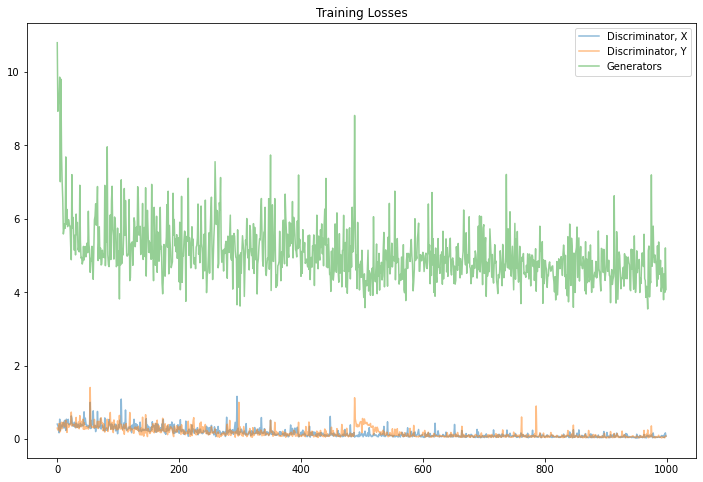

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/sample-004000-summer2winter.png?raw=1' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


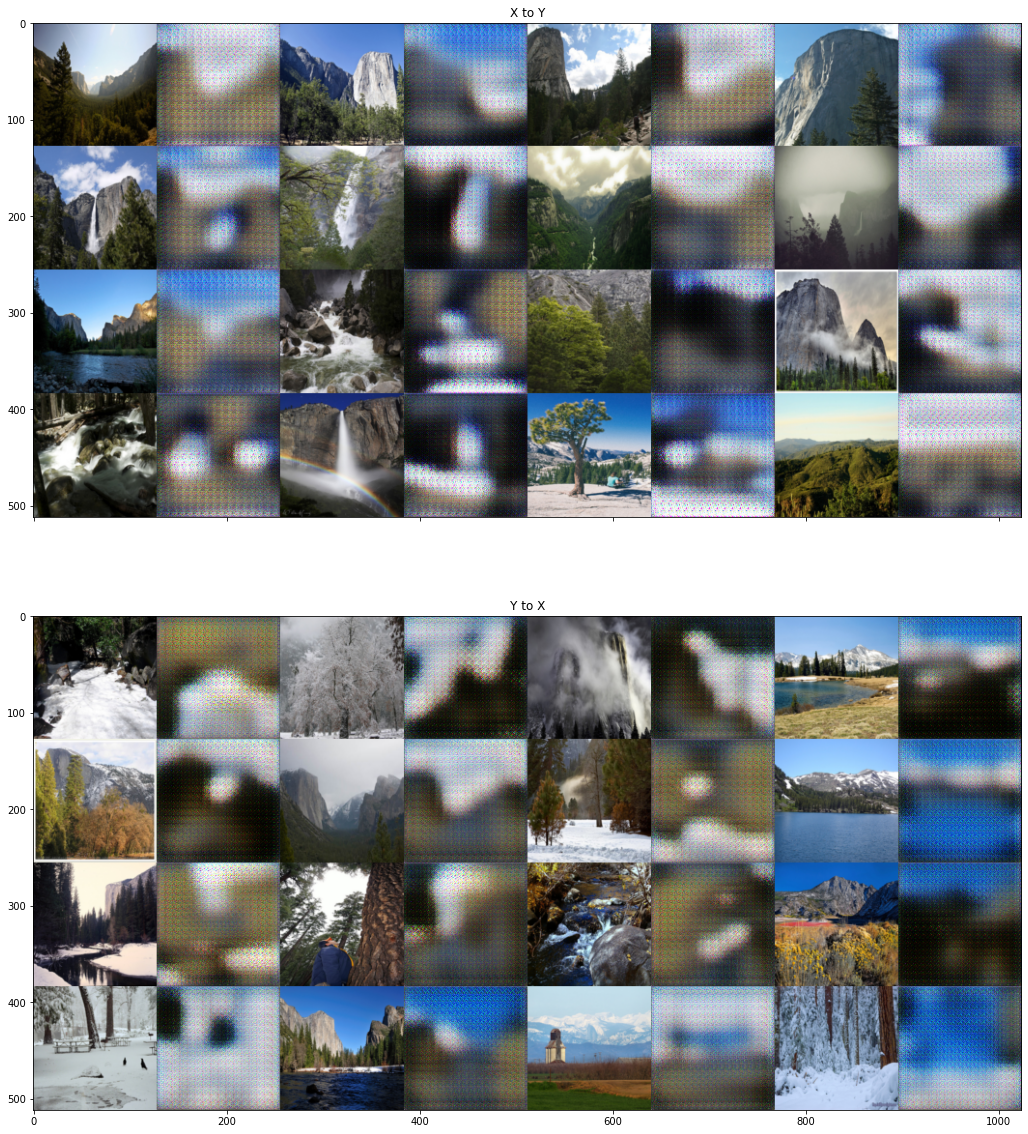

In [30]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

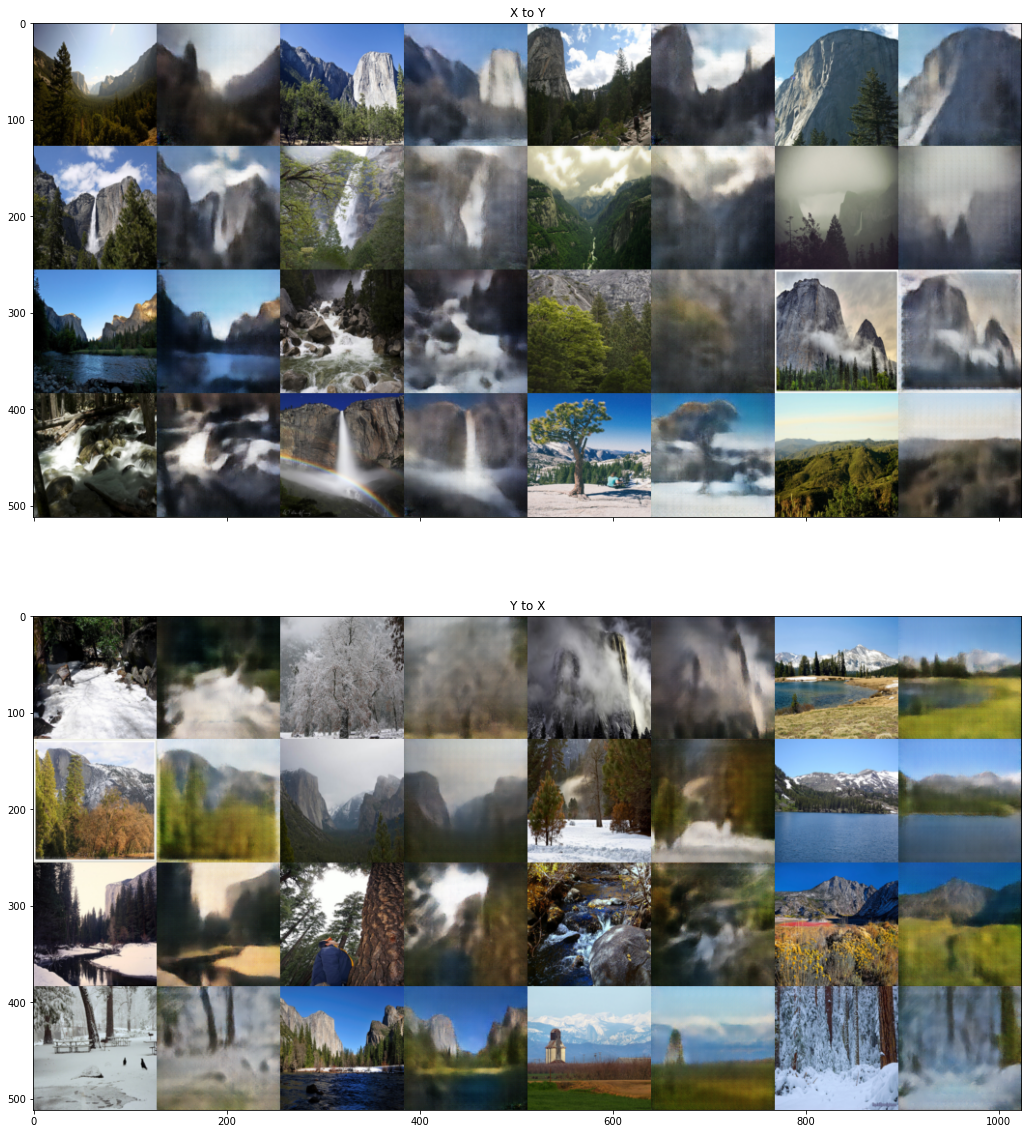

In [31]:
# view samples at iteration 10000
view_samples(10000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.